In [1]:
import os
import logging
import dill as pickle
import urllib
import random
from tqdm import tqdm
import sys
import codecs
import spacy
import time

import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tarfile
import torchtext.data
import torchtext.datasets

import argparse

In [2]:
device = torch.device("cuda", index=2)
output_dir = './output_lambda=0.1'
lambda_ = 0.1

In [3]:
_TRAIN_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/" \
             "training-parallel-nc-v12.tgz",
     "trg": "news-commentary-v12.de-en.en",
     "src": "news-commentary-v12.de-en.de"}
    ]

_VAL_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/dev.tgz",
     "trg": "newstest2013.en",
     "src": "newstest2013.de"}]

_TEST_DATA_SOURCES = [
    {"url": "https://storage.googleapis.com/tf-perf-public/" \
                "official_transformer/test_data/newstest2014.tgz",
     "trg": "newstest2014.en",
     "src": "newstest2014.de"}]

In [4]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def file_exist(dir_name, file_name):
    for sub_dir, _, files in os.walk(dir_name):
        if file_name in files:
            return os.path.join(sub_dir, file_name)
    return None

In [5]:
def download_and_extract(download_dir, url, src_filename, trg_filename):
    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        sys.stderr.write(f"Already downloaded and extracted {url}.\n")
        return src_path, trg_path

    compressed_file = _download_file(download_dir, url)

    sys.stderr.write(f"Extracting {compressed_file}.\n")
    with tarfile.open(compressed_file, "r:gz") as corpus_tar:
        corpus_tar.extractall(download_dir)

    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        return src_path, trg_path

    raise OSError(f"Download/extraction failed for url {url} to path {download_dir}")

def _download_file(download_dir, url):
    filename = url.split("/")[-1]
    if file_exist(download_dir, filename):
        sys.stderr.write(f"Already downloaded: {url} (at {filename}).\n")
    else:
        sys.stderr.write(f"Downloading from {url} to {filename}.\n")
        with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc=filename) as t:
            urllib.request.urlretrieve(url, filename=filename, reporthook=t.update_to)
    return filename

def get_raw_files(raw_dir, sources):
    raw_files = { "src": [], "trg": [], }
    for d in sources:
        src_file, trg_file = download_and_extract(raw_dir, d["url"], d["src"], d["trg"])
        raw_files["src"].append(src_file)
        raw_files["trg"].append(trg_file)
    return raw_files

In [6]:
def mkdir_if_needed(dir_name):
    if not os.path.isdir(dir_name):
        os.makedirs(dir_name)

In [7]:
def compile_files(raw_dir, raw_files, prefix):
    src_fpath = os.path.join(raw_dir, f"raw-{prefix}.src")
    trg_fpath = os.path.join(raw_dir, f"raw-{prefix}.trg")

    if os.path.isfile(src_fpath) and os.path.isfile(trg_fpath):
        sys.stderr.write(f"Merged files found, skip the merging process.\n")
        return src_fpath, trg_fpath

    sys.stderr.write(f"Merge files into two files: {src_fpath} and {trg_fpath}.\n")

    with open(src_fpath, 'w') as src_outf, open(trg_fpath, 'w') as trg_outf:
        for src_inf, trg_inf in zip(raw_files['src'], raw_files['trg']):
            sys.stderr.write(f'  Input files: \n'\
                    f'    - SRC: {src_inf}, and\n' \
                    f'    - TRG: {trg_inf}.\n')
            with open(src_inf, newline='\n') as src_inf, open(trg_inf, newline='\n') as trg_inf:
                cntr = 0
                for i, line in enumerate(src_inf):
                    cntr += 1
                    src_outf.write(line.replace('\r', ' ').strip() + '\n')
                for j, line in enumerate(trg_inf):
                    cntr -= 1
                    trg_outf.write(line.replace('\r', ' ').strip() + '\n')
                assert cntr == 0, 'Number of lines in two files are inconsistent.'
    return src_fpath, trg_fpath

In [8]:
def encode_file(bpe, in_file, out_file):
    sys.stderr.write(f"Read raw content from {in_file} and \n"\
            f"Write encoded content to {out_file}\n")
    
    with codecs.open(in_file, encoding='utf-8') as in_f:
        with codecs.open(out_file, 'w', encoding='utf-8') as out_f:
            for line in in_f:
                out_f.write(bpe.process_line(line))

def encode_files(bpe, src_in_file, trg_in_file, data_dir, prefix):
    src_out_file = os.path.join(data_dir, f"{prefix}.src")
    trg_out_file = os.path.join(data_dir, f"{prefix}.trg")

    if os.path.isfile(src_out_file) and os.path.isfile(trg_out_file):
        sys.stderr.write(f"Encoded files found, skip the encoding process ...\n")

    encode_file(bpe, src_in_file, src_out_file)
    encode_file(bpe, trg_in_file, trg_out_file)
    return src_out_file, trg_out_file

In [9]:
src_lang_model = spacy.load('de_core_news_sm')
trg_lang_model = spacy.load('en_core_web_sm')

In [10]:
PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
BOS_WORD = '<s>'
EOS_WORD = '</s>'

In [11]:
def tokenize_src(text):
        return [tok.text for tok in src_lang_model.tokenizer(text)]

def tokenize_trg(text):
    return [tok.text for tok in trg_lang_model.tokenizer(text)]

SRC = torchtext.legacy.data.Field(
    tokenize=tokenize_src, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

TRG = torchtext.legacy.data.Field(
    tokenize=tokenize_trg, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

In [12]:
MAX_LEN = 100
MIN_FREQ = 3

In [13]:
def filter_examples_with_length(x):
    return len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN

In [14]:
ROOT = '../Datasets/Multi30k/'
train, val, test = torchtext.legacy.datasets.Multi30k.splits(
            root=ROOT,
            exts = ('.' + 'de', '.' + 'en'),
            fields = (SRC, TRG),
            filter_pred=filter_examples_with_length)

In [15]:
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
print('[Info] Get source language vocabulary size:', len(SRC.vocab))
TRG.build_vocab(train.trg, min_freq=MIN_FREQ)
print('[Info] Get target language vocabulary size:', len(TRG.vocab))

[Info] Get source language vocabulary size: 5374
[Info] Get target language vocabulary size: 4556


In [16]:
print('[Info] Merging two vocabulary ...')
for w, _ in SRC.vocab.stoi.items():
    if w not in TRG.vocab.stoi:
        TRG.vocab.stoi[w] = len(TRG.vocab.stoi)
TRG.vocab.itos = [None] * len(TRG.vocab.stoi)
for w, i in TRG.vocab.stoi.items():
    TRG.vocab.itos[i] = w
SRC.vocab.stoi = TRG.vocab.stoi
SRC.vocab.itos = TRG.vocab.itos
print('[Info] Get merged vocabulary size:', len(TRG.vocab))

[Info] Merging two vocabulary ...
[Info] Get merged vocabulary size: 9521


In [17]:
spacy_support_langs = ['de', 'el', 'en', 'es', 'fr', 'it', 'lt', 'nb', 'nl', 'pt']

parser = argparse.ArgumentParser()
parser.add_argument('-lang_src', required=True, choices=spacy_support_langs)
parser.add_argument('-lang_trg', required=True, choices=spacy_support_langs)
parser.add_argument('-save_data', required=True)
parser.add_argument('-data_src', type=str, default=None)
parser.add_argument('-data_trg', type=str, default=None)

parser.add_argument('-max_len', type=int, default=100)
parser.add_argument('-min_word_count', type=int, default=3)
parser.add_argument('-keep_case', action='store_true')
parser.add_argument('-share_vocab', action='store_true')

opt = parser.parse_args(args=['-lang_src', 'de', '-lang_trg', 'en', '-share_vocab', '-save_data', './m30k_deen_shr.pkl'])

In [18]:
data = {
    'settings': opt,
    'vocab': {'src': SRC, 'trg': TRG},
    'train': train.examples,
    'valid': val.examples,
    'test': test.examples}

print('[Info] Dumping the processed data to pickle file', opt.save_data)
pickle.dump(data, open(opt.save_data, 'wb'))

[Info] Dumping the processed data to pickle file ./m30k_deen_shr.pkl


# 学習設定

In [19]:
parser = argparse.ArgumentParser()

parser.add_argument('-data_pkl', default=None)     # all-in-1 data pickle or bpe field
parser.add_argument('-train_path', default=None)   # bpe encoded data
parser.add_argument('-val_path', default=None)     # bpe encoded data
parser.add_argument('-epoch', type=int, default=10)
parser.add_argument('-b', '--batch_size', type=int, default=2048)
parser.add_argument('-d_model', type=int, default=512)
parser.add_argument('-d_inner_hid', type=int, default=2048)
parser.add_argument('-d_k', type=int, default=64)
parser.add_argument('-d_v', type=int, default=64)
parser.add_argument('-n_head', type=int, default=8)
parser.add_argument('-n_layers', type=int, default=6)
parser.add_argument('-warmup','--n_warmup_steps', type=int, default=4000)
parser.add_argument('-lr_mul', type=float, default=2.0)
parser.add_argument('-seed', type=int, default=None)
parser.add_argument('-dropout', type=float, default=0.1)
parser.add_argument('-embs_share_weight', action='store_true')
parser.add_argument('-proj_share_weight', action='store_true')
parser.add_argument('-scale_emb_or_prj', type=str, default='prj')
parser.add_argument('-output_dir', type=str, default=None)
parser.add_argument('-use_tb', action='store_true')
parser.add_argument('-save_mode', type=str, choices=['all', 'best'], default='best')
parser.add_argument('-no_cuda', action='store_true')
parser.add_argument('-label_smoothing', action='store_true')

opt = parser.parse_args(
    args=['-data_pkl', './m30k_deen_shr.pkl', '-seed', '428', '-embs_share_weight', '-proj_share_weight', '-label_smoothing', '-output_dir', output_dir, '-b', '512', '-warmup', '128000', '-epoch', '1000'])
opt.cuda = not opt.no_cuda
opt.d_word_vec = opt.d_model

In [20]:
if opt.seed is not None:
    torch.manual_seed(opt.seed)
    torch.backends.cudnn.benchmark = False
    np.random.seed(opt.seed)
    random.seed(opt.seed)

In [21]:
if opt.batch_size < 2048 and opt.n_warmup_steps <= 4000:
    print('[Warning] The warmup steps may be not enough.\n'\
            '(sz_b, warmup) = (2048, 4000) is the official setting.\n'\
            'Using smaller batch w/o longer warmup may cause '\
            'the warmup stage ends with only little data trained.')

In [22]:
def prepare_dataloaders(opt, device):
    batch_size = opt.batch_size
    data = pickle.load(open(opt.data_pkl, 'rb'))

    opt.max_token_seq_len = data['settings'].max_len
    opt.src_pad_idx = data['vocab']['src'].vocab.stoi[PAD_WORD]
    opt.trg_pad_idx = data['vocab']['trg'].vocab.stoi[PAD_WORD]

    opt.src_vocab_size = len(data['vocab']['src'].vocab)
    opt.trg_vocab_size = len(data['vocab']['trg'].vocab)

    if opt.embs_share_weight:
        assert data['vocab']['src'].vocab.stoi == data['vocab']['trg'].vocab.stoi, \
            'To sharing word embedding the src/trg word2idx table shall be the same.'

    fields = {'src': data['vocab']['src'], 'trg':data['vocab']['trg']}

    train = torchtext.legacy.data.Dataset(examples=data['train'], fields=fields)
    val = torchtext.legacy.data.Dataset(examples=data['valid'], fields=fields)

    train_iterator = torchtext.legacy.data.BucketIterator(train, batch_size=batch_size, device=device, train=True)
    val_iterator = torchtext.legacy.data.BucketIterator(val, batch_size=batch_size, device=device)

    return train_iterator, val_iterator

In [23]:
training_data, validation_data = prepare_dataloaders(opt, device)

# Gate 付き Transformer の実装と実体化

In [24]:
class BinaryGate(nn.Module):
    
    def __init__(self, num_gates: int, init: float=0.0):
        super(BinaryGate, self).__init__()
        
        self.num_gates = num_gates
        self.gate = nn.parameter.Parameter(torch.zeros(num_gates).fill_(init))
    
    def forward(self, beta=0.667, gamma=-0.1, zeta = 1.0, 
                hard = True, eps = 1e-6, threshold=0.5):
        
        loss_constant = (beta * math.log(-gamma / zeta)) if (gamma < 0) else 0.0
        
        if self.training:
            noise = torch.zeros(self.num_gates)
            noise = noise.cuda(self.gate.device)
            
            noise.data.uniform_(eps, 1 - eps)
            u = noise.data
            
            s = torch.log(u) - torch.log(1.0 - u)
            
            s = (s + self.gate) / beta
            s = torch.sigmoid(s)
        else:
            s = torch.sigmoid(self.gate)
        
        s = s * (zeta - gamma) + gamma
        out = torch.clamp(s, eps, 1)
        
        if hard:
            out_hard = torch.greater_equal(out, threshold).float()
            out = out + (out_hard - out).detach()
            sparsity = torch.eq(out, 0).sum()
        else:
            sparsity = torch.less(out, threshold).float().sum()
        
        l0_loss = torch.sigmoid(self.gate - loss_constant)
        l0_loss = torch.clamp(l0_loss, eps, 1.0 - eps).sum()
        
        return out, l0_loss, (sparsity.detach().cpu(), self.num_gates)

In [25]:
class ScaledDotProductAttention(nn.Module):

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn

In [26]:
class MultiHeadAttention(nn.Module):

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.gate = BinaryGate(num_gates=n_head, init=2.0)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q
        
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)
        
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
        
        bin_mask, l0_loss, sparsity = self.gate()
        bin_mask = torch.cat([bin_mask[i].repeat(self.d_model//self.n_head) for i in range(self.n_head)])
        
        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)
        
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q *= bin_mask
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn, l0_loss, sparsity


class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x

In [27]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        enc_output, enc_slf_attn, l0_loss, sparsity = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        
        return enc_output, enc_slf_attn, l0_loss, sparsity


class DecoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(
            self, dec_input, enc_output,
            slf_attn_mask=None, dec_enc_attn_mask=None):
        dec_output, dec_slf_attn, l0_loss1, sparsity1 = self.slf_attn(
            dec_input, dec_input, dec_input, mask=slf_attn_mask)
        dec_output, dec_enc_attn, l0_loss2, sparsity2 = self.enc_attn(
            dec_output, enc_output, enc_output, mask=dec_enc_attn_mask)
        dec_output = self.pos_ffn(dec_output)
        
        return dec_output, dec_slf_attn, dec_enc_attn, l0_loss1+l0_loss2, sparsity1, sparsity2

In [28]:
def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)


def get_subsequent_mask(seq):
    sz_b, len_s = seq.size()
    subsequent_mask = (1 - torch.triu(
        torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask


class PositionalEncoding(nn.Module):

    def __init__(self, d_hid, n_position=200):
        super(PositionalEncoding, self).__init__()
        
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, d_hid))

    def _get_sinusoid_encoding_table(self, n_position, d_hid):

        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()


class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(
            self, n_src_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, dropout=0.1, n_position=200, scale_emb=False):

        super().__init__()

        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, src_seq, src_mask, return_attns=False):

        enc_slf_attn_list = []
        l0_loss = 0.0
        sparsity = [0, 0]
        
        enc_output = self.src_word_emb(src_seq)
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5
        enc_output = self.dropout(self.position_enc(enc_output))
        enc_output = self.layer_norm(enc_output)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn, l0, spa = enc_layer(enc_output, slf_attn_mask=src_mask)
            enc_slf_attn_list += [enc_slf_attn] if return_attns else []
            l0_loss += l0
            sparsity[0] += spa[0]
            sparsity[1] += spa[1]

        if return_attns:
            return enc_output, l0_loss, sparsity, enc_slf_attn_list
        return enc_output, l0_loss, sparsity,


class Decoder(nn.Module):

    def __init__(
            self, n_trg_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, n_position=200, dropout=0.1, scale_emb=False):

        super().__init__()

        self.trg_word_emb = nn.Embedding(n_trg_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, trg_seq, trg_mask, enc_output, src_mask, return_attns=False):

        dec_slf_attn_list, dec_enc_attn_list = [], []
        l0_loss = 0.0
        sparsity1 = [0, 0]
        sparsity2 = [0, 0]
        
        dec_output = self.trg_word_emb(trg_seq)
        if self.scale_emb:
            dec_output *= self.d_model ** 0.5
        dec_output = self.dropout(self.position_enc(dec_output))
        dec_output = self.layer_norm(dec_output)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn, l0, spa1, spa2 = dec_layer(
                dec_output, enc_output, slf_attn_mask=trg_mask, dec_enc_attn_mask=src_mask)
            dec_slf_attn_list += [dec_slf_attn] if return_attns else []
            dec_enc_attn_list += [dec_enc_attn] if return_attns else []
            l0_loss += l0
            sparsity1[0] += spa1[0]
            sparsity1[1] += spa1[1]
            sparsity2[0] += spa2[0]
            sparsity2[1] += spa2[1]

        if return_attns:
            return dec_output, l0_loss, sparsity1, sparsity2, dec_slf_attn_list, dec_enc_attn_list
        return dec_output, l0_loss, sparsity1, sparsity2,

In [29]:
class Transformer(nn.Module):

    def __init__(
            self, n_src_vocab, n_trg_vocab, src_pad_idx, trg_pad_idx,
            d_word_vec=512, d_model=512, d_inner=2048,
            n_layers=6, n_head=8, d_k=64, d_v=64, dropout=0.1, n_position=200,
            trg_emb_prj_weight_sharing=True, emb_src_trg_weight_sharing=True,
            scale_emb_or_prj='prj'):

        super().__init__()

        self.src_pad_idx, self.trg_pad_idx = src_pad_idx, trg_pad_idx

        assert scale_emb_or_prj in ['emb', 'prj', 'none']
        scale_emb = (scale_emb_or_prj == 'emb') if trg_emb_prj_weight_sharing else False
        self.scale_prj = (scale_emb_or_prj == 'prj') if trg_emb_prj_weight_sharing else False
        self.d_model = d_model

        self.encoder = Encoder(
            n_src_vocab=n_src_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=src_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.decoder = Decoder(
            n_trg_vocab=n_trg_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=trg_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.trg_word_prj = nn.Linear(d_model, n_trg_vocab, bias=False)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p) 

        assert d_model == d_word_vec, \
        'To facilitate the residual connections, \
         the dimensions of all module outputs shall be the same.'

        if trg_emb_prj_weight_sharing:
            self.trg_word_prj.weight = self.decoder.trg_word_emb.weight

        if emb_src_trg_weight_sharing:
            self.encoder.src_word_emb.weight = self.decoder.trg_word_emb.weight


    def forward(self, src_seq, trg_seq):

        src_mask = get_pad_mask(src_seq, self.src_pad_idx)
        trg_mask = get_pad_mask(trg_seq, self.trg_pad_idx) & get_subsequent_mask(trg_seq)

        enc_output, l0_loss1, sparsity1, *_ = self.encoder(src_seq, src_mask)
        dec_output, l0_loss2, sparsity2, sparsity3, *_ = self.decoder(trg_seq, trg_mask, enc_output, src_mask)
        seq_logit = self.trg_word_prj(dec_output)
        if self.scale_prj:
            seq_logit *= self.d_model ** -0.5

        return seq_logit.view(-1, seq_logit.size(2)), l0_loss1+l0_loss2, (sparsity1, sparsity2, sparsity3)

In [30]:
transformer = Transformer(
        opt.src_vocab_size,
        opt.trg_vocab_size,
        src_pad_idx=opt.src_pad_idx,
        trg_pad_idx=opt.trg_pad_idx,
        trg_emb_prj_weight_sharing=opt.proj_share_weight,
        emb_src_trg_weight_sharing=opt.embs_share_weight,
        d_k=opt.d_k,
        d_v=opt.d_v,
        d_model=opt.d_model,
        d_word_vec=opt.d_word_vec,
        d_inner=opt.d_inner_hid,
        n_layers=opt.n_layers,
        n_head=opt.n_head,
        dropout=opt.dropout,
        scale_emb_or_prj=opt.scale_emb_or_prj).to(device)

# Optimizer の実装と実体化

In [31]:
class ScheduledOptim():

    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))


    def _update_learning_rate(self):

        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [32]:
optimizer = ScheduledOptim(
        optim.Adam(transformer.parameters(), betas=(0.9, 0.98), eps=1e-09),
        opt.lr_mul, opt.d_model, opt.n_warmup_steps)

# 訓練と検証

In [33]:
def cal_performance(pred, gold, trg_pad_idx, smoothing=False):

    loss = cal_loss(pred, gold, trg_pad_idx, smoothing=smoothing)

    pred = pred.max(1)[1]
    gold = gold.contiguous().view(-1)
    non_pad_mask = gold.ne(trg_pad_idx)
    n_correct = pred.eq(gold).masked_select(non_pad_mask).sum().item()
    n_word = non_pad_mask.sum().item()

    return loss, n_correct, n_word


def cal_loss(pred, gold, trg_pad_idx, smoothing=False):

    gold = gold.contiguous().view(-1)

    if smoothing:
        eps = 0.1
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        non_pad_mask = gold.ne(trg_pad_idx)
        loss = -(one_hot * log_prb).sum(dim=1)
        loss = loss.masked_select(non_pad_mask).sum()  # average later
    else:
        loss = F.cross_entropy(pred, gold, ignore_index=trg_pad_idx, reduction='sum')
    return loss


def patch_src(src, pad_idx):
    src = src.transpose(0, 1)
    return src


def patch_trg(trg, pad_idx):
    trg = trg.transpose(0, 1)
    trg, gold = trg[:, :-1], trg[:, 1:].contiguous().view(-1)
    return trg, gold


def train_epoch(model, training_data, optimizer, opt, device, smoothing, lambda_):

    model.train()
    total_loss, n_word_total, n_word_correct = 0, 0, 0 
    enc_sparsity = [0, 0]
    dec_sparsity1 = [0, 0]
    dec_sparsity2 = [0, 0]
    
    desc = '  - (Training)   '
    for batch in tqdm(training_data, mininterval=2, desc=desc, leave=False):
        
        src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
        trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

        # forward
        optimizer.zero_grad()
        pred, l0_loss, sparsity = model(src_seq, trg_seq)

        # backward and update parameters
        loss, n_correct, n_word = cal_performance(
            pred, gold, opt.trg_pad_idx, smoothing=smoothing)
        loss_ = loss + lambda_ * l0_loss
        loss_.backward()
        optimizer.step_and_update_lr()

        # note keeping
        n_word_total += n_word
        n_word_correct += n_correct
        total_loss += loss.item()
        enc_sparsity[0] += sparsity[0][0]
        enc_sparsity[1] += sparsity[0][1]
        dec_sparsity1[0] += sparsity[1][0]
        dec_sparsity1[1] += sparsity[1][1]
        dec_sparsity2[0] += sparsity[2][0]
        dec_sparsity2[1] += sparsity[2][1]
        

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy, (enc_sparsity, dec_sparsity1, dec_sparsity2)


def eval_epoch(model, validation_data, device, opt, lambda_):

    model.eval()
    total_loss, n_word_total, n_word_correct = 0, 0, 0

    desc = '  - (Validation) '
    with torch.no_grad():
        for batch in tqdm(validation_data, mininterval=2, desc=desc, leave=False):

            # prepare data
            src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
            trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

            # forward
            pred, l0_loss, sparsity = model(src_seq, trg_seq)
            loss, n_correct, n_word = cal_performance(
                pred, gold, opt.trg_pad_idx, smoothing=False)
            
            # note keeping
            n_word_total += n_word
            n_word_correct += n_correct
            total_loss += loss.item()

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy

In [34]:
def train(model, training_data, validation_data, optimizer, device, opt, lambda_=0.0):
    if opt.use_tb:
        print("[Info] Use Tensorboard")
        from torch.utils.tensorboard import SummaryWriter
        tb_writer = SummaryWriter(log_dir=os.path.join(opt.output_dir, 'tensorboard'))

    log_train_file = os.path.join(opt.output_dir, 'train.log')
    log_valid_file = os.path.join(opt.output_dir, 'valid.log')
    log_sparsity_file = os.path.join(opt.output_dir, 'sparsity.log')

    print('[Info] Training performance will be written to file: {} and {}'.format(
        log_train_file, log_valid_file, log_sparsity_file))

    with open(log_train_file, 'w') as log_tf, open(log_valid_file, 'w') as log_vf, open(log_sparsity_file, 'w') as log_sf:
        log_tf.write('epoch,loss,ppl,accuracy\n')
        log_vf.write('epoch,loss,ppl,accuracy\n')
        log_sf.write('epoch,enc-sa,dec-sa, dec-enc\n')

    def print_performances(header, ppl, accu, start_time, lr):
        print('  - {header:12} ppl: {ppl: 8.5f}, accuracy: {accu:3.3f} %, lr: {lr:8.5f}, '\
              'elapse: {elapse:3.3f} min'.format(
                  header=f"({header})", ppl=ppl,
                  accu=100*accu, elapse=(time.time()-start_time)/60, lr=lr))

    valid_losses = []
    for epoch_i in range(opt.epoch):
        print('[ Epoch', epoch_i, ']')

        start = time.time()
        train_loss, train_accu, sparsity = train_epoch(
            model, training_data, optimizer, opt, device, smoothing=opt.label_smoothing, lambda_=lambda_)
        train_ppl = math.exp(min(train_loss, 100))
        lr = optimizer._optimizer.param_groups[0]['lr']
        print_performances('Training', train_ppl, train_accu, start, lr)

        start = time.time()
        valid_loss, valid_accu = eval_epoch(model, validation_data, device, opt, lambda_=lambda_)
        valid_ppl = math.exp(min(valid_loss, 100))
        print_performances('Validation', valid_ppl, valid_accu, start, lr)

        valid_losses += [valid_loss]

        checkpoint = {'epoch': epoch_i, 'settings': opt, 'model': model.state_dict()}

        if opt.save_mode == 'all':
            model_name = 'model_accu_{accu:3.3f}.chkpt'.format(accu=100*valid_accu)
            torch.save(checkpoint, model_name)
        elif opt.save_mode == 'best':
            model_name = 'model.chkpt'
            if valid_loss <= min(valid_losses):
                torch.save(checkpoint, os.path.join(opt.output_dir, model_name))
                print('    - [Info] The checkpoint file has been updated.')

        with open(log_train_file, 'a') as log_tf, open(log_valid_file, 'a') as log_vf, open(log_sparsity_file, 'a') as log_sf:
            log_tf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=train_loss,
                ppl=train_ppl, accu=100*train_accu))
            log_vf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=valid_loss,
                ppl=valid_ppl, accu=100*valid_accu))
            log_sf.write('{epoch},{enc: 3.3f},{dec1: 3.3f},{dec2: 3.3f}\n'.format(
                epoch=epoch_i, 
                enc =(sparsity[0][1]-sparsity[0][0])/sparsity[0][1],
                dec1=(sparsity[1][1]-sparsity[1][0])/sparsity[1][1],
                dec2=(sparsity[2][1]-sparsity[2][0])/sparsity[2][1]))

        if opt.use_tb:
            tb_writer.add_scalars('ppl', {'train': train_ppl, 'val': valid_ppl}, epoch_i)
            tb_writer.add_scalars('accuracy', {'train': train_accu*100, 'val': valid_accu*100}, epoch_i)
            tb_writer.add_scalar('learning_rate', lr, epoch_i)

In [35]:
train(transformer, training_data, validation_data, optimizer, device, opt, lambda_=lambda_)

[Info] Training performance will be written to file: ./output_lambda=0.1/train.log and ./output_lambda=0.1/valid.log
[ Epoch 0 ]


  - (Training)   ppl:  9500.33826, accuracy: 0.006 %, lr:  0.00000, elapse: 0.308 min


  - (Validation) ppl:  9474.57718, accuracy: 0.000 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 1 ]


  - (Training)   ppl:  9484.22100, accuracy: 0.012 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  9435.46182, accuracy: 0.000 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 2 ]


  - (Training)   ppl:  9453.71184, accuracy: 0.848 %, lr:  0.00000, elapse: 0.305 min


  - (Validation) ppl:  9377.63548, accuracy: 11.981 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 3 ]


  - (Training)   ppl:  9412.59618, accuracy: 6.186 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  9315.28115, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 4 ]


  - (Training)   ppl:  9361.59024, accuracy: 11.625 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  9256.47094, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 5 ]


  - (Training)   ppl:  9316.18397, accuracy: 11.957 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  9202.75087, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 6 ]


  - (Training)   ppl:  9271.09247, accuracy: 12.014 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  9155.00722, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 7 ]


  - (Training)   ppl:  9233.23838, accuracy: 12.015 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  9114.49368, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 8 ]


  - (Training)   ppl:  9198.37593, accuracy: 12.015 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  9078.45125, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 9 ]


  - (Training)   ppl:  9164.51258, accuracy: 12.015 %, lr:  0.00000, elapse: 0.319 min


  - (Validation) ppl:  9043.89195, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 10 ]


  - (Training)   ppl:  9132.23386, accuracy: 12.015 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  9012.63556, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 11 ]


  - (Training)   ppl:  9102.60194, accuracy: 12.015 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8982.85033, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 12 ]


  - (Training)   ppl:  9071.91020, accuracy: 12.015 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8953.86836, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 13 ]


  - (Training)   ppl:  9044.64769, accuracy: 12.015 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8925.93602, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 14 ]


  - (Training)   ppl:  9017.21016, accuracy: 12.015 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8897.96566, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 15 ]


  - (Training)   ppl:  8988.09261, accuracy: 12.015 %, lr:  0.00000, elapse: 0.319 min


  - (Validation) ppl:  8869.34393, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 16 ]


  - (Training)   ppl:  8962.55160, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8840.30248, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 17 ]


  - (Training)   ppl:  8932.18473, accuracy: 12.015 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  8809.66630, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 18 ]


  - (Training)   ppl:  8902.71441, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8777.21759, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 19 ]


  - (Training)   ppl:  8870.91140, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8742.37646, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 20 ]


  - (Training)   ppl:  8839.27516, accuracy: 12.015 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  8704.39059, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 21 ]


  - (Training)   ppl:  8802.35520, accuracy: 12.015 %, lr:  0.00000, elapse: 0.317 min


  - (Validation) ppl:  8661.26123, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 22 ]


  - (Training)   ppl:  8760.94081, accuracy: 12.015 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8614.50428, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 23 ]


  - (Training)   ppl:  8719.30724, accuracy: 12.016 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8565.91168, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 24 ]


  - (Training)   ppl:  8674.82059, accuracy: 12.160 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8516.91117, accuracy: 13.830 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 25 ]


  - (Training)   ppl:  8628.26419, accuracy: 13.394 %, lr:  0.00000, elapse: 0.317 min


  - (Validation) ppl:  8463.29928, accuracy: 16.281 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 26 ]


  - (Training)   ppl:  8581.22838, accuracy: 15.141 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8407.04963, accuracy: 16.468 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 27 ]


  - (Training)   ppl:  8534.67131, accuracy: 15.923 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8361.96586, accuracy: 16.205 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 28 ]


  - (Training)   ppl:  8487.99969, accuracy: 16.344 %, lr:  0.00000, elapse: 0.320 min


  - (Validation) ppl:  8302.44489, accuracy: 17.161 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 29 ]


  - (Training)   ppl:  8439.25904, accuracy: 16.603 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8249.60499, accuracy: 17.639 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 30 ]


  - (Training)   ppl:  8391.79326, accuracy: 16.771 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8197.08365, accuracy: 17.438 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 31 ]


  - (Training)   ppl:  8343.37876, accuracy: 16.919 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8140.12348, accuracy: 17.742 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 32 ]


  - (Training)   ppl:  8293.55829, accuracy: 16.956 %, lr:  0.00000, elapse: 0.318 min


  - (Validation) ppl:  8090.84421, accuracy: 17.735 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 33 ]


  - (Training)   ppl:  8242.85978, accuracy: 17.090 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8029.56615, accuracy: 17.722 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 34 ]


  - (Training)   ppl:  8191.59649, accuracy: 16.939 %, lr:  0.00000, elapse: 0.317 min


  - (Validation) ppl:  7969.87323, accuracy: 18.165 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 35 ]


  - (Training)   ppl:  8136.78141, accuracy: 17.071 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  7912.73221, accuracy: 17.791 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 36 ]


  - (Training)   ppl:  8081.73859, accuracy: 17.126 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  7846.91887, accuracy: 17.922 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 37 ]


  - (Training)   ppl:  8026.67272, accuracy: 17.044 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  7784.88066, accuracy: 17.846 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 38 ]


  - (Training)   ppl:  7969.36804, accuracy: 17.106 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  7722.34267, accuracy: 18.234 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 39 ]


  - (Training)   ppl:  7910.65298, accuracy: 17.084 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  7658.12946, accuracy: 17.445 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 40 ]


  - (Training)   ppl:  7850.65850, accuracy: 16.970 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  7589.41853, accuracy: 18.172 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 41 ]


  - (Training)   ppl:  7790.40281, accuracy: 17.003 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  7521.63337, accuracy: 18.006 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 42 ]


  - (Training)   ppl:  7728.65418, accuracy: 16.863 %, lr:  0.00000, elapse: 0.319 min


  - (Validation) ppl:  7453.33454, accuracy: 17.839 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 43 ]


  - (Training)   ppl:  7665.19322, accuracy: 16.911 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  7384.59705, accuracy: 18.082 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 44 ]


  - (Training)   ppl:  7600.86413, accuracy: 16.841 %, lr:  0.00000, elapse: 0.323 min


  - (Validation) ppl:  7316.38858, accuracy: 18.560 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 45 ]


  - (Training)   ppl:  7536.10486, accuracy: 16.640 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  7242.48304, accuracy: 18.054 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 46 ]


  - (Training)   ppl:  7469.07345, accuracy: 16.534 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  7166.94673, accuracy: 17.278 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 47 ]


  - (Training)   ppl:  7401.78261, accuracy: 16.484 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  7094.47207, accuracy: 16.150 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 48 ]


  - (Training)   ppl:  7334.24580, accuracy: 16.427 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  7017.80785, accuracy: 17.327 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 49 ]


  - (Training)   ppl:  7264.62984, accuracy: 16.520 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  6941.91950, accuracy: 17.929 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 50 ]


  - (Training)   ppl:  7194.14321, accuracy: 16.244 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  6864.67688, accuracy: 17.583 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 51 ]


  - (Training)   ppl:  7124.18284, accuracy: 16.134 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  6788.01646, accuracy: 17.784 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 52 ]


  - (Training)   ppl:  7051.91399, accuracy: 15.979 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  6711.37876, accuracy: 17.916 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 53 ]


  - (Training)   ppl:  6978.68261, accuracy: 15.936 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  6630.76506, accuracy: 16.565 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 54 ]


  - (Training)   ppl:  6906.30599, accuracy: 15.817 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  6551.19762, accuracy: 17.202 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 55 ]


  - (Training)   ppl:  6833.00078, accuracy: 15.801 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  6471.06710, accuracy: 16.683 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 56 ]


  - (Training)   ppl:  6758.53579, accuracy: 15.663 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  6390.62343, accuracy: 15.997 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 57 ]


  - (Training)   ppl:  6683.93950, accuracy: 15.373 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  6312.21789, accuracy: 13.864 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 58 ]


  - (Training)   ppl:  6608.66955, accuracy: 15.101 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  6228.47969, accuracy: 16.371 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 59 ]


  - (Training)   ppl:  6531.68227, accuracy: 15.037 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  6146.26968, accuracy: 16.191 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 60 ]


  - (Training)   ppl:  6455.19294, accuracy: 14.894 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  6063.15982, accuracy: 15.616 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 61 ]


  - (Training)   ppl:  6377.79716, accuracy: 14.717 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  5981.11391, accuracy: 15.693 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 62 ]


  - (Training)   ppl:  6301.99912, accuracy: 14.446 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5898.74830, accuracy: 15.783 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 63 ]


  - (Training)   ppl:  6223.48439, accuracy: 14.335 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  5815.12222, accuracy: 13.712 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 64 ]


  - (Training)   ppl:  6145.35242, accuracy: 14.173 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  5732.43514, accuracy: 14.169 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 65 ]


  - (Training)   ppl:  6067.23535, accuracy: 13.921 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  5648.60682, accuracy: 13.781 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 66 ]


  - (Training)   ppl:  5989.29291, accuracy: 13.726 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  5566.40792, accuracy: 13.089 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 67 ]


  - (Training)   ppl:  5911.16859, accuracy: 13.431 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  5482.20387, accuracy: 13.324 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 68 ]


  - (Training)   ppl:  5831.83122, accuracy: 13.323 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  5398.46741, accuracy: 12.791 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 69 ]


  - (Training)   ppl:  5753.04152, accuracy: 13.147 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  5316.52913, accuracy: 12.590 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 70 ]


  - (Training)   ppl:  5673.50303, accuracy: 12.987 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  5231.69749, accuracy: 12.126 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 71 ]


  - (Training)   ppl:  5594.94412, accuracy: 12.797 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  5148.58156, accuracy: 12.791 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 72 ]


  - (Training)   ppl:  5517.03667, accuracy: 12.641 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  5066.75319, accuracy: 12.084 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 73 ]


  - (Training)   ppl:  5436.75236, accuracy: 12.542 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  4984.72700, accuracy: 12.064 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 74 ]


  - (Training)   ppl:  5358.71927, accuracy: 12.501 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  4900.62847, accuracy: 12.064 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 75 ]


  - (Training)   ppl:  5279.51854, accuracy: 12.355 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  4818.22510, accuracy: 12.071 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 76 ]


  - (Training)   ppl:  5201.28782, accuracy: 12.308 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4736.65504, accuracy: 12.015 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 77 ]


  - (Training)   ppl:  5122.32762, accuracy: 12.249 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  4656.09686, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 78 ]


  - (Training)   ppl:  5044.03915, accuracy: 12.163 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  4574.04464, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 79 ]


  - (Training)   ppl:  4966.28728, accuracy: 12.164 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  4493.18920, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 80 ]


  - (Training)   ppl:  4888.86214, accuracy: 12.084 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  4412.28394, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 81 ]


  - (Training)   ppl:  4811.43293, accuracy: 12.099 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4333.42977, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 82 ]


  - (Training)   ppl:  4733.93020, accuracy: 12.058 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  4253.93485, accuracy: 12.001 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 83 ]


  - (Training)   ppl:  4657.05779, accuracy: 12.061 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  4175.41476, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 84 ]


  - (Training)   ppl:  4581.04087, accuracy: 12.046 %, lr:  0.00001, elapse: 0.321 min


  - (Validation) ppl:  4096.24475, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 85 ]


  - (Training)   ppl:  4505.00597, accuracy: 12.033 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  4019.28580, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 86 ]


  - (Training)   ppl:  4429.65473, accuracy: 12.028 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3942.46606, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 87 ]


  - (Training)   ppl:  4354.78431, accuracy: 12.023 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  3865.94099, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 88 ]


  - (Training)   ppl:  4280.26329, accuracy: 12.023 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3790.13432, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 89 ]


  - (Training)   ppl:  4206.13228, accuracy: 12.019 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3715.28141, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 90 ]


  - (Training)   ppl:  4133.00318, accuracy: 12.018 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3640.87545, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 91 ]


  - (Training)   ppl:  4060.16273, accuracy: 12.018 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  3568.22506, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 92 ]


  - (Training)   ppl:  3987.41730, accuracy: 12.016 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  3495.26333, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 93 ]


  - (Training)   ppl:  3915.89282, accuracy: 12.016 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  3423.86296, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 94 ]


  - (Training)   ppl:  3844.97459, accuracy: 12.016 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  3352.50970, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 95 ]


  - (Training)   ppl:  3774.60336, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  3282.33265, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 96 ]


  - (Training)   ppl:  3704.56701, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3212.99178, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 97 ]


  - (Training)   ppl:  3635.59209, accuracy: 12.016 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3144.18002, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 98 ]


  - (Training)   ppl:  3567.05386, accuracy: 12.015 %, lr:  0.00001, elapse: 0.320 min


  - (Validation) ppl:  3076.89525, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 99 ]


  - (Training)   ppl:  3499.35811, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3009.58049, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 100 ]


  - (Training)   ppl:  3432.20272, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2945.70599, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 101 ]


  - (Training)   ppl:  3366.20646, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2879.11713, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 102 ]


  - (Training)   ppl:  3300.76254, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2814.78346, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 103 ]


  - (Training)   ppl:  3236.35105, accuracy: 12.015 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  2751.94464, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 104 ]


  - (Training)   ppl:  3172.84547, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2690.24667, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 105 ]


  - (Training)   ppl:  3109.17215, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2628.48884, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 106 ]


  - (Training)   ppl:  3047.00548, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2568.67262, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 107 ]


  - (Training)   ppl:  2985.67350, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  2508.18196, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 108 ]


  - (Training)   ppl:  2924.78818, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2450.28281, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 109 ]


  - (Training)   ppl:  2864.98683, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2392.97112, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 110 ]


  - (Training)   ppl:  2806.10670, accuracy: 12.015 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  2336.71168, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 111 ]


  - (Training)   ppl:  2747.87257, accuracy: 12.015 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  2280.91586, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 112 ]


  - (Training)   ppl:  2690.55426, accuracy: 12.015 %, lr:  0.00001, elapse: 0.319 min


  - (Validation) ppl:  2226.98361, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 113 ]


  - (Training)   ppl:  2634.43793, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2173.14758, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 114 ]


  - (Training)   ppl:  2578.60119, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2121.45416, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 115 ]


  - (Training)   ppl:  2523.90697, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  2070.00294, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 116 ]


  - (Training)   ppl:  2470.09000, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2018.06660, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 117 ]


  - (Training)   ppl:  2417.13238, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1968.96354, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 118 ]


  - (Training)   ppl:  2365.01018, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1920.40576, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 119 ]


  - (Training)   ppl:  2313.51790, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1871.87946, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 120 ]


  - (Training)   ppl:  2263.39880, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1824.55074, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 121 ]


  - (Training)   ppl:  2213.69056, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1779.10773, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 122 ]


  - (Training)   ppl:  2165.15324, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  1734.48918, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 123 ]


  - (Training)   ppl:  2117.40950, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  1689.45471, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 124 ]


  - (Training)   ppl:  2070.45371, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1646.46403, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 125 ]


  - (Training)   ppl:  2024.21873, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1604.45056, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 126 ]


  - (Training)   ppl:  1979.36297, accuracy: 12.015 %, lr:  0.00001, elapse: 0.321 min


  - (Validation) ppl:  1564.30072, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 127 ]


  - (Training)   ppl:  1934.83706, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1522.82547, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 128 ]


  - (Training)   ppl:  1891.52542, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1483.41185, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 129 ]


  - (Training)   ppl:  1848.63006, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  1444.61419, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 130 ]


  - (Training)   ppl:  1806.97417, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  1407.98182, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 131 ]


  - (Training)   ppl:  1765.92827, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1370.37865, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 132 ]


  - (Training)   ppl:  1725.79263, accuracy: 12.015 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  1334.60048, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 133 ]


  - (Training)   ppl:  1686.53343, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  1299.17007, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 134 ]


  - (Training)   ppl:  1648.00371, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1264.83867, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 135 ]


  - (Training)   ppl:  1610.40901, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1231.72400, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 136 ]


  - (Training)   ppl:  1573.40732, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  1199.32867, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 137 ]


  - (Training)   ppl:  1537.48481, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  1167.26898, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 138 ]


  - (Training)   ppl:  1502.19854, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  1136.01189, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 139 ]


  - (Training)   ppl:  1467.52174, accuracy: 12.015 %, lr:  0.00002, elapse: 0.320 min


  - (Validation) ppl:  1106.04709, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 140 ]


  - (Training)   ppl:  1433.85497, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  1076.66704, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 141 ]


  - (Training)   ppl:  1400.99975, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  1047.71931, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 142 ]


  - (Training)   ppl:  1368.60508, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  1019.75951, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 143 ]


  - (Training)   ppl:  1337.00620, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  992.70429, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 144 ]


  - (Training)   ppl:  1306.38372, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  966.05060, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 145 ]


  - (Training)   ppl:  1276.11888, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  939.96557, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 146 ]


  - (Training)   ppl:  1246.79471, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  915.36902, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 147 ]


  - (Training)   ppl:  1218.16385, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  890.51299, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 148 ]


  - (Training)   ppl:  1190.11157, accuracy: 12.015 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  866.54800, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 149 ]


  - (Training)   ppl:  1162.74690, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  843.16386, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 150 ]


  - (Training)   ppl:  1136.09390, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  820.72528, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 151 ]


  - (Training)   ppl:  1110.25697, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  798.88839, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 152 ]


  - (Training)   ppl:  1084.82648, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  777.55573, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 153 ]


  - (Training)   ppl:  1060.11530, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  756.90532, accuracy: 11.988 %, lr:  0.00002, elapse: 0.009 min
    - [Info] The checkpoint file has been updated.
[ Epoch 154 ]


  - (Training)   ppl:  1036.01281, accuracy: 12.015 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  736.59708, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 155 ]


  - (Training)   ppl:  1012.60993, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  717.23059, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 156 ]


  - (Training)   ppl:  989.71465, accuracy: 12.015 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  698.19722, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 157 ]


  - (Training)   ppl:  967.44142, accuracy: 12.015 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  679.68825, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 158 ]


  - (Training)   ppl:  945.78850, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  661.79418, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 159 ]


  - (Training)   ppl:  924.65310, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  644.41235, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 160 ]


  - (Training)   ppl:  904.16889, accuracy: 12.015 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  627.60893, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 161 ]


  - (Training)   ppl:  884.24459, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  611.37266, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 162 ]


  - (Training)   ppl:  864.82873, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  595.39115, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 163 ]


  - (Training)   ppl:  845.94111, accuracy: 12.015 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  579.96843, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 164 ]


  - (Training)   ppl:  827.62668, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  565.09546, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 165 ]


  - (Training)   ppl:  809.76365, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  550.77715, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 166 ]


  - (Training)   ppl:  792.49697, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  536.78636, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 167 ]


  - (Training)   ppl:  775.73120, accuracy: 12.015 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  523.23856, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 168 ]


  - (Training)   ppl:  759.39380, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  510.10071, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 169 ]


  - (Training)   ppl:  743.49762, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  497.48367, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 170 ]


  - (Training)   ppl:  728.11230, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  485.17136, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 171 ]


  - (Training)   ppl:  713.22615, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  473.29011, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 172 ]


  - (Training)   ppl:  698.74897, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  461.78077, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 173 ]


  - (Training)   ppl:  684.63842, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  450.67624, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 174 ]


  - (Training)   ppl:  671.03316, accuracy: 12.015 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  439.95549, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 175 ]


  - (Training)   ppl:  657.81389, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  429.52312, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 176 ]


  - (Training)   ppl:  644.98459, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  419.47268, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 177 ]


  - (Training)   ppl:  632.59024, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  409.66982, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 178 ]


  - (Training)   ppl:  620.56281, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  400.27315, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 179 ]


  - (Training)   ppl:  608.93187, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  391.30356, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 180 ]


  - (Training)   ppl:  597.63583, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  382.41630, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 181 ]


  - (Training)   ppl:  586.71541, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  373.93000, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 182 ]


  - (Training)   ppl:  576.15173, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  365.78754, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 183 ]


  - (Training)   ppl:  565.97038, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  357.89712, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 184 ]


  - (Training)   ppl:  556.11997, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  350.24104, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 185 ]


  - (Training)   ppl:  546.61833, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  342.99092, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 186 ]


  - (Training)   ppl:  537.40745, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  335.85562, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 187 ]


  - (Training)   ppl:  528.54294, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  329.08172, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 188 ]


  - (Training)   ppl:  520.01780, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  322.44767, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 189 ]


  - (Training)   ppl:  511.80392, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  316.12655, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 190 ]


  - (Training)   ppl:  503.87149, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  310.06302, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 191 ]


  - (Training)   ppl:  496.28621, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  304.22399, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 192 ]


  - (Training)   ppl:  489.01304, accuracy: 12.015 %, lr:  0.00002, elapse: 0.307 min


  - (Validation) ppl:  298.61453, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 193 ]


  - (Training)   ppl:  482.06438, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  293.29649, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 194 ]


  - (Training)   ppl:  475.38223, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  288.17767, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 195 ]


  - (Training)   ppl:  469.00558, accuracy: 12.015 %, lr:  0.00002, elapse: 0.319 min


  - (Validation) ppl:  283.28341, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 196 ]


  - (Training)   ppl:  462.85757, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  278.49661, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 197 ]


  - (Training)   ppl:  456.94661, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  274.05042, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 198 ]


  - (Training)   ppl:  451.24153, accuracy: 12.016 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  269.61131, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 199 ]


  - (Training)   ppl:  445.87040, accuracy: 12.017 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  265.43108, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 200 ]


  - (Training)   ppl:  440.47146, accuracy: 12.024 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  261.54162, accuracy: 11.994 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 201 ]


  - (Training)   ppl:  435.14363, accuracy: 12.056 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  257.45253, accuracy: 12.050 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 202 ]


  - (Training)   ppl:  430.17471, accuracy: 12.082 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  253.68300, accuracy: 12.050 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 203 ]


  - (Training)   ppl:  425.15890, accuracy: 12.118 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  249.99957, accuracy: 12.105 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 204 ]


  - (Training)   ppl:  420.49079, accuracy: 12.183 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  246.35570, accuracy: 12.133 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 205 ]


  - (Training)   ppl:  415.72805, accuracy: 12.206 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  243.23764, accuracy: 12.036 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 206 ]


  - (Training)   ppl:  411.36009, accuracy: 12.217 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  239.93612, accuracy: 12.015 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 207 ]


  - (Training)   ppl:  406.93990, accuracy: 12.298 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  236.46317, accuracy: 12.209 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 208 ]


  - (Training)   ppl:  402.51678, accuracy: 12.294 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  233.23833, accuracy: 12.154 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 209 ]


  - (Training)   ppl:  398.35672, accuracy: 12.340 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  230.13546, accuracy: 12.064 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 210 ]


  - (Training)   ppl:  394.11519, accuracy: 12.356 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  226.95295, accuracy: 12.043 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 211 ]


  - (Training)   ppl:  390.12544, accuracy: 12.383 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  223.97411, accuracy: 12.036 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 212 ]


  - (Training)   ppl:  386.16761, accuracy: 12.368 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  221.45883, accuracy: 12.036 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 213 ]


  - (Training)   ppl:  382.50022, accuracy: 12.371 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  217.89088, accuracy: 12.001 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 214 ]


  - (Training)   ppl:  378.29669, accuracy: 12.373 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  215.90553, accuracy: 12.029 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 215 ]


  - (Training)   ppl:  374.64394, accuracy: 12.434 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  212.78818, accuracy: 12.078 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 216 ]


  - (Training)   ppl:  370.90550, accuracy: 12.451 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  210.49000, accuracy: 12.036 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 217 ]


  - (Training)   ppl:  367.11240, accuracy: 12.514 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  207.79626, accuracy: 12.188 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 218 ]


  - (Training)   ppl:  363.41412, accuracy: 12.578 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  205.78806, accuracy: 12.181 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 219 ]


  - (Training)   ppl:  359.78373, accuracy: 12.727 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  203.31437, accuracy: 12.258 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 220 ]


  - (Training)   ppl:  356.29439, accuracy: 12.887 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  201.53193, accuracy: 12.569 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 221 ]


  - (Training)   ppl:  352.41619, accuracy: 13.184 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  198.77487, accuracy: 13.920 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 222 ]


  - (Training)   ppl:  348.85330, accuracy: 13.402 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  194.98243, accuracy: 12.999 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 223 ]


  - (Training)   ppl:  345.08753, accuracy: 13.690 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  193.28595, accuracy: 13.989 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 224 ]


  - (Training)   ppl:  341.39515, accuracy: 14.102 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  190.09212, accuracy: 13.255 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 225 ]


  - (Training)   ppl:  337.73710, accuracy: 14.380 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  187.93503, accuracy: 13.989 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 226 ]


  - (Training)   ppl:  334.00313, accuracy: 14.848 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  185.91342, accuracy: 15.575 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 227 ]


  - (Training)   ppl:  330.06436, accuracy: 15.160 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  182.97144, accuracy: 13.802 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 228 ]


  - (Training)   ppl:  326.27827, accuracy: 15.484 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  180.88355, accuracy: 14.287 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 229 ]


  - (Training)   ppl:  322.51943, accuracy: 15.954 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  178.84986, accuracy: 15.963 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 230 ]


  - (Training)   ppl:  318.73848, accuracy: 16.329 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  176.30126, accuracy: 15.741 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 231 ]


  - (Training)   ppl:  315.08098, accuracy: 16.580 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  174.17320, accuracy: 16.676 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 232 ]


  - (Training)   ppl:  311.05153, accuracy: 17.122 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  170.70004, accuracy: 17.458 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 233 ]


  - (Training)   ppl:  307.26540, accuracy: 17.589 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  169.62910, accuracy: 17.770 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 234 ]


  - (Training)   ppl:  303.27420, accuracy: 18.842 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  166.41227, accuracy: 17.583 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 235 ]


  - (Training)   ppl:  299.60584, accuracy: 20.247 %, lr:  0.00003, elapse: 0.306 min


  - (Validation) ppl:  163.48316, accuracy: 16.801 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 236 ]


  - (Training)   ppl:  296.14761, accuracy: 21.908 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  162.29204, accuracy: 18.144 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 237 ]


  - (Training)   ppl:  292.45098, accuracy: 23.184 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  158.57003, accuracy: 24.702 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 238 ]


  - (Training)   ppl:  288.58575, accuracy: 24.313 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  156.67630, accuracy: 24.633 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 239 ]


  - (Training)   ppl:  285.03466, accuracy: 24.493 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  153.80680, accuracy: 24.744 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 240 ]


  - (Training)   ppl:  280.88139, accuracy: 24.741 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  151.72563, accuracy: 24.591 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 241 ]


  - (Training)   ppl:  277.39151, accuracy: 24.780 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  151.17655, accuracy: 24.820 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 242 ]


  - (Training)   ppl:  273.20686, accuracy: 24.840 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  147.96698, accuracy: 24.896 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 243 ]


  - (Training)   ppl:  270.20622, accuracy: 24.870 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  146.04615, accuracy: 25.000 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 244 ]


  - (Training)   ppl:  266.36869, accuracy: 24.963 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  142.14706, accuracy: 24.931 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 245 ]


  - (Training)   ppl:  262.86544, accuracy: 25.095 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  139.97031, accuracy: 25.166 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 246 ]


  - (Training)   ppl:  259.02148, accuracy: 25.264 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  139.31253, accuracy: 25.547 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 247 ]


  - (Training)   ppl:  255.20735, accuracy: 25.694 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  136.92159, accuracy: 26.101 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 248 ]


  - (Training)   ppl:  251.90084, accuracy: 26.217 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  134.67766, accuracy: 27.957 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 249 ]


  - (Training)   ppl:  248.54885, accuracy: 26.896 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  132.77539, accuracy: 28.033 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 250 ]


  - (Training)   ppl:  244.78061, accuracy: 27.439 %, lr:  0.00003, elapse: 0.320 min


  - (Validation) ppl:  129.54820, accuracy: 28.303 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 251 ]


  - (Training)   ppl:  241.36722, accuracy: 27.805 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  129.81008, accuracy: 28.123 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 252 ]


  - (Training)   ppl:  238.11965, accuracy: 28.068 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  125.37225, accuracy: 28.331 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 253 ]


  - (Training)   ppl:  234.78140, accuracy: 28.265 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  122.68619, accuracy: 28.421 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 254 ]


  - (Training)   ppl:  231.28713, accuracy: 28.369 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  121.33571, accuracy: 28.470 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 255 ]


  - (Training)   ppl:  227.62449, accuracy: 28.477 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  119.65486, accuracy: 28.539 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 256 ]


  - (Training)   ppl:  224.47032, accuracy: 28.580 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  116.68949, accuracy: 28.560 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 257 ]


  - (Training)   ppl:  221.55137, accuracy: 28.625 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  114.73464, accuracy: 28.677 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 258 ]


  - (Training)   ppl:  218.39025, accuracy: 28.656 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  113.86209, accuracy: 28.670 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 259 ]


  - (Training)   ppl:  215.27357, accuracy: 28.696 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  111.17536, accuracy: 28.802 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 260 ]


  - (Training)   ppl:  212.08350, accuracy: 28.749 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  109.16610, accuracy: 28.719 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 261 ]


  - (Training)   ppl:  209.00707, accuracy: 28.771 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  108.01468, accuracy: 28.767 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 262 ]


  - (Training)   ppl:  206.31268, accuracy: 28.804 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  106.50578, accuracy: 28.802 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 263 ]


  - (Training)   ppl:  203.22055, accuracy: 28.837 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  106.60318, accuracy: 28.726 %, lr:  0.00003, elapse: 0.003 min
[ Epoch 264 ]


  - (Training)   ppl:  200.58147, accuracy: 28.853 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  103.45698, accuracy: 28.906 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 265 ]


  - (Training)   ppl:  197.39308, accuracy: 28.936 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  100.75689, accuracy: 28.940 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 266 ]


  - (Training)   ppl:  195.14203, accuracy: 28.909 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  99.68350, accuracy: 28.920 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 267 ]


  - (Training)   ppl:  192.25243, accuracy: 28.997 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  98.32795, accuracy: 29.051 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 268 ]


  - (Training)   ppl:  189.72568, accuracy: 28.998 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  96.99592, accuracy: 28.947 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 269 ]


  - (Training)   ppl:  186.87341, accuracy: 29.054 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  95.25503, accuracy: 29.107 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 270 ]


  - (Training)   ppl:  184.66179, accuracy: 29.040 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  93.72376, accuracy: 29.114 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 271 ]


  - (Training)   ppl:  182.24894, accuracy: 29.078 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  92.93573, accuracy: 29.072 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 272 ]


  - (Training)   ppl:  180.10843, accuracy: 29.113 %, lr:  0.00003, elapse: 0.318 min


  - (Validation) ppl:  90.54062, accuracy: 29.107 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 273 ]


  - (Training)   ppl:  177.67718, accuracy: 29.136 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  89.37927, accuracy: 29.197 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 274 ]


  - (Training)   ppl:  175.33077, accuracy: 29.176 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  88.07162, accuracy: 29.224 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 275 ]


  - (Training)   ppl:  172.85806, accuracy: 29.227 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  87.14876, accuracy: 29.301 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 276 ]


  - (Training)   ppl:  170.75963, accuracy: 29.245 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  85.63458, accuracy: 29.349 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 277 ]


  - (Training)   ppl:  168.65977, accuracy: 29.272 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  84.47712, accuracy: 29.411 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 278 ]


  - (Training)   ppl:  166.69795, accuracy: 29.279 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  83.33881, accuracy: 29.356 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 279 ]


  - (Training)   ppl:  164.52258, accuracy: 29.377 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  82.29309, accuracy: 29.695 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 280 ]


  - (Training)   ppl:  162.65623, accuracy: 29.458 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  80.55566, accuracy: 29.529 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 281 ]


  - (Training)   ppl:  160.90478, accuracy: 29.522 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  80.18383, accuracy: 29.778 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 282 ]


  - (Training)   ppl:  158.70130, accuracy: 29.642 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  78.74977, accuracy: 29.813 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 283 ]


  - (Training)   ppl:  157.26285, accuracy: 29.706 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  77.97222, accuracy: 29.792 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 284 ]


  - (Training)   ppl:  155.37650, accuracy: 29.782 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  76.76532, accuracy: 30.048 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 285 ]


  - (Training)   ppl:  153.68088, accuracy: 29.874 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  76.38145, accuracy: 30.083 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 286 ]


  - (Training)   ppl:  151.72802, accuracy: 29.978 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  74.78357, accuracy: 30.083 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 287 ]


  - (Training)   ppl:  150.29004, accuracy: 30.021 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  74.18831, accuracy: 30.055 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 288 ]


  - (Training)   ppl:  148.46795, accuracy: 30.149 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  73.09546, accuracy: 30.215 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 289 ]


  - (Training)   ppl:  146.75344, accuracy: 30.220 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  72.32391, accuracy: 30.450 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 290 ]


  - (Training)   ppl:  145.30561, accuracy: 30.307 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  71.39203, accuracy: 30.519 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 291 ]


  - (Training)   ppl:  143.84813, accuracy: 30.374 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  70.89591, accuracy: 30.568 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 292 ]


  - (Training)   ppl:  142.49395, accuracy: 30.442 %, lr:  0.00003, elapse: 0.318 min


  - (Validation) ppl:  69.55836, accuracy: 30.651 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 293 ]


  - (Training)   ppl:  140.91682, accuracy: 30.572 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  68.57758, accuracy: 30.686 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 294 ]


  - (Training)   ppl:  139.67231, accuracy: 30.625 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  67.61412, accuracy: 30.762 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 295 ]


  - (Training)   ppl:  138.15574, accuracy: 30.800 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  67.35740, accuracy: 30.672 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 296 ]


  - (Training)   ppl:  136.90830, accuracy: 30.851 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  66.72506, accuracy: 30.928 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 297 ]


  - (Training)   ppl:  135.80970, accuracy: 30.962 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  65.65333, accuracy: 31.053 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 298 ]


  - (Training)   ppl:  134.10891, accuracy: 31.122 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  65.12969, accuracy: 31.073 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 299 ]


  - (Training)   ppl:  133.06019, accuracy: 31.182 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  64.36228, accuracy: 31.150 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 300 ]


  - (Training)   ppl:  131.98697, accuracy: 31.275 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  63.87148, accuracy: 31.247 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 301 ]


  - (Training)   ppl:  130.80823, accuracy: 31.385 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  62.72188, accuracy: 31.496 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 302 ]


  - (Training)   ppl:  129.49215, accuracy: 31.516 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  62.12473, accuracy: 31.884 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 303 ]


  - (Training)   ppl:  128.57113, accuracy: 31.588 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  61.64451, accuracy: 31.745 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 304 ]


  - (Training)   ppl:  127.18800, accuracy: 31.746 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  61.58275, accuracy: 31.863 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 305 ]


  - (Training)   ppl:  126.30781, accuracy: 31.822 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  60.69873, accuracy: 32.168 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 306 ]


  - (Training)   ppl:  124.83590, accuracy: 31.967 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  59.88327, accuracy: 32.361 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 307 ]


  - (Training)   ppl:  124.00677, accuracy: 32.079 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  59.89271, accuracy: 32.424 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 308 ]


  - (Training)   ppl:  123.00579, accuracy: 32.114 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  59.20588, accuracy: 32.507 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 309 ]


  - (Training)   ppl:  121.96844, accuracy: 32.270 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  58.78155, accuracy: 32.452 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 310 ]


  - (Training)   ppl:  120.81823, accuracy: 32.374 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  57.95605, accuracy: 32.777 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 311 ]


  - (Training)   ppl:  119.88466, accuracy: 32.464 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  57.79778, accuracy: 32.687 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 312 ]


  - (Training)   ppl:  118.93337, accuracy: 32.579 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  56.84895, accuracy: 32.694 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 313 ]


  - (Training)   ppl:  117.99540, accuracy: 32.623 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  55.84695, accuracy: 32.874 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 314 ]


  - (Training)   ppl:  117.09705, accuracy: 32.743 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  56.05663, accuracy: 32.985 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 315 ]


  - (Training)   ppl:  116.32785, accuracy: 32.728 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  55.64503, accuracy: 33.040 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 316 ]


  - (Training)   ppl:  115.61469, accuracy: 32.814 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  55.40660, accuracy: 33.068 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 317 ]


  - (Training)   ppl:  114.45801, accuracy: 32.907 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  53.97081, accuracy: 33.289 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 318 ]


  - (Training)   ppl:  113.95689, accuracy: 32.898 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  53.67464, accuracy: 33.289 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 319 ]


  - (Training)   ppl:  112.96137, accuracy: 33.028 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  53.00958, accuracy: 33.470 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 320 ]


  - (Training)   ppl:  112.15492, accuracy: 33.146 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  53.47293, accuracy: 33.511 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 321 ]


  - (Training)   ppl:  111.49271, accuracy: 33.226 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  52.80054, accuracy: 33.622 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 322 ]


  - (Training)   ppl:  110.92825, accuracy: 33.244 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  52.36981, accuracy: 33.781 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 323 ]


  - (Training)   ppl:  109.86844, accuracy: 33.430 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  51.51075, accuracy: 33.906 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 324 ]


  - (Training)   ppl:  109.19600, accuracy: 33.513 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  51.80953, accuracy: 33.913 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 325 ]


  - (Training)   ppl:  108.37888, accuracy: 33.605 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  50.84028, accuracy: 34.017 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 326 ]


  - (Training)   ppl:  107.60230, accuracy: 33.755 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  50.40808, accuracy: 33.996 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 327 ]


  - (Training)   ppl:  106.95327, accuracy: 33.840 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  49.78294, accuracy: 34.217 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 328 ]


  - (Training)   ppl:  106.26319, accuracy: 33.908 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  49.99733, accuracy: 34.363 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 329 ]


  - (Training)   ppl:  105.52354, accuracy: 33.980 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  49.53561, accuracy: 34.488 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 330 ]


  - (Training)   ppl:  105.07842, accuracy: 34.039 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  49.14103, accuracy: 34.598 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 331 ]


  - (Training)   ppl:  104.32909, accuracy: 34.115 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  48.79285, accuracy: 34.702 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 332 ]


  - (Training)   ppl:  103.35943, accuracy: 34.232 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  48.30871, accuracy: 34.695 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 333 ]


  - (Training)   ppl:  102.60437, accuracy: 34.327 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  48.08507, accuracy: 34.917 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 334 ]


  - (Training)   ppl:  102.42350, accuracy: 34.300 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  48.24854, accuracy: 34.744 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 335 ]


  - (Training)   ppl:  101.38163, accuracy: 34.497 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  47.32952, accuracy: 35.104 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 336 ]


  - (Training)   ppl:  100.76573, accuracy: 34.569 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  47.08015, accuracy: 35.145 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 337 ]


  - (Training)   ppl:  100.29132, accuracy: 34.625 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  46.45023, accuracy: 35.208 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 338 ]


  - (Training)   ppl:  99.50069, accuracy: 34.713 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  46.19680, accuracy: 35.443 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 339 ]


  - (Training)   ppl:  98.78587, accuracy: 34.809 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  45.99741, accuracy: 35.360 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 340 ]


  - (Training)   ppl:  98.59110, accuracy: 34.803 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  45.77688, accuracy: 35.637 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 341 ]


  - (Training)   ppl:  97.87467, accuracy: 34.934 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  45.20476, accuracy: 35.644 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 342 ]


  - (Training)   ppl:  96.80363, accuracy: 35.141 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  45.31560, accuracy: 35.665 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 343 ]


  - (Training)   ppl:  96.32205, accuracy: 35.251 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  44.60800, accuracy: 35.831 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 344 ]


  - (Training)   ppl:  95.61368, accuracy: 35.348 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  44.64608, accuracy: 36.032 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 345 ]


  - (Training)   ppl:  95.11984, accuracy: 35.417 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  43.64424, accuracy: 35.942 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 346 ]


  - (Training)   ppl:  94.35150, accuracy: 35.474 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  43.64666, accuracy: 36.143 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 347 ]


  - (Training)   ppl:  93.88744, accuracy: 35.518 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  43.26949, accuracy: 36.143 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 348 ]


  - (Training)   ppl:  93.28555, accuracy: 35.658 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  43.62617, accuracy: 35.866 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 349 ]


  - (Training)   ppl:  93.10140, accuracy: 35.623 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  42.35232, accuracy: 36.170 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 350 ]


  - (Training)   ppl:  92.21494, accuracy: 35.741 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  42.65094, accuracy: 36.205 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 351 ]


  - (Training)   ppl:  91.63599, accuracy: 35.841 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  41.99117, accuracy: 36.371 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 352 ]


  - (Training)   ppl:  91.14593, accuracy: 35.811 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  42.18271, accuracy: 36.427 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 353 ]


  - (Training)   ppl:  90.50347, accuracy: 35.880 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  41.46425, accuracy: 36.163 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 354 ]


  - (Training)   ppl:  90.10501, accuracy: 35.874 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  41.12292, accuracy: 36.572 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 355 ]


  - (Training)   ppl:  89.36370, accuracy: 36.028 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  40.76819, accuracy: 36.627 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 356 ]


  - (Training)   ppl:  88.64297, accuracy: 36.088 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  40.95168, accuracy: 36.247 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 357 ]


  - (Training)   ppl:  88.08074, accuracy: 36.094 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  39.78516, accuracy: 36.627 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 358 ]


  - (Training)   ppl:  87.62222, accuracy: 36.184 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  39.80601, accuracy: 36.821 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 359 ]


  - (Training)   ppl:  87.06230, accuracy: 36.159 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  39.94433, accuracy: 37.237 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 360 ]


  - (Training)   ppl:  86.69918, accuracy: 36.229 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  39.13711, accuracy: 37.126 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 361 ]


  - (Training)   ppl:  85.77148, accuracy: 36.433 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  38.52861, accuracy: 37.071 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 362 ]


  - (Training)   ppl:  85.35264, accuracy: 36.532 %, lr:  0.00004, elapse: 0.318 min


  - (Validation) ppl:  38.44074, accuracy: 37.410 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 363 ]


  - (Training)   ppl:  84.74039, accuracy: 36.644 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  38.22641, accuracy: 37.500 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 364 ]


  - (Training)   ppl:  84.00870, accuracy: 36.881 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  38.26289, accuracy: 37.611 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 365 ]


  - (Training)   ppl:  83.50863, accuracy: 36.980 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  37.58473, accuracy: 37.881 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 366 ]


  - (Training)   ppl:  82.93470, accuracy: 37.092 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  37.49103, accuracy: 37.770 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 367 ]


  - (Training)   ppl:  82.53901, accuracy: 37.187 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  37.25070, accuracy: 37.999 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 368 ]


  - (Training)   ppl:  82.18563, accuracy: 37.295 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  37.04723, accuracy: 37.832 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 369 ]


  - (Training)   ppl:  81.50935, accuracy: 37.410 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  36.83615, accuracy: 37.867 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 370 ]


  - (Training)   ppl:  81.30460, accuracy: 37.440 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  36.77353, accuracy: 37.909 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 371 ]


  - (Training)   ppl:  80.66705, accuracy: 37.541 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  36.36893, accuracy: 38.172 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 372 ]


  - (Training)   ppl:  80.16087, accuracy: 37.642 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  36.15408, accuracy: 38.040 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 373 ]


  - (Training)   ppl:  79.71529, accuracy: 37.716 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  36.12670, accuracy: 38.102 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 374 ]


  - (Training)   ppl:  79.49863, accuracy: 37.702 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  35.56721, accuracy: 37.971 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 375 ]


  - (Training)   ppl:  78.76024, accuracy: 37.902 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  35.46229, accuracy: 38.476 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 376 ]


  - (Training)   ppl:  78.22398, accuracy: 38.013 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  35.49013, accuracy: 38.657 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 377 ]


  - (Training)   ppl:  77.84759, accuracy: 38.034 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  35.16285, accuracy: 38.421 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 378 ]


  - (Training)   ppl:  77.32114, accuracy: 38.167 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  35.02083, accuracy: 38.359 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 379 ]


  - (Training)   ppl:  76.91491, accuracy: 38.197 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  34.44016, accuracy: 38.830 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 380 ]


  - (Training)   ppl:  76.49582, accuracy: 38.344 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  34.56781, accuracy: 38.906 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 381 ]


  - (Training)   ppl:  75.86789, accuracy: 38.436 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  34.39506, accuracy: 38.594 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 382 ]


  - (Training)   ppl:  75.37607, accuracy: 38.567 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  33.88050, accuracy: 39.134 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 383 ]


  - (Training)   ppl:  75.15038, accuracy: 38.596 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  33.86150, accuracy: 39.183 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 384 ]


  - (Training)   ppl:  74.77529, accuracy: 38.683 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  33.70737, accuracy: 39.127 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 385 ]


  - (Training)   ppl:  74.55402, accuracy: 38.673 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  33.53546, accuracy: 39.176 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 386 ]


  - (Training)   ppl:  73.88828, accuracy: 38.834 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  33.26813, accuracy: 39.460 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 387 ]


  - (Training)   ppl:  73.66779, accuracy: 38.906 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  32.75820, accuracy: 39.411 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 388 ]


  - (Training)   ppl:  73.20515, accuracy: 38.972 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  32.99876, accuracy: 39.647 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 389 ]


  - (Training)   ppl:  72.79917, accuracy: 39.092 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  32.56354, accuracy: 39.917 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 390 ]


  - (Training)   ppl:  72.50794, accuracy: 39.140 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  32.23531, accuracy: 40.055 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 391 ]


  - (Training)   ppl:  71.89852, accuracy: 39.256 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  32.13045, accuracy: 39.855 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 392 ]


  - (Training)   ppl:  71.14260, accuracy: 39.454 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  32.35397, accuracy: 39.917 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 393 ]


  - (Training)   ppl:  70.95478, accuracy: 39.481 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  31.96750, accuracy: 39.938 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 394 ]


  - (Training)   ppl:  70.63933, accuracy: 39.551 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  31.52786, accuracy: 40.263 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 395 ]


  - (Training)   ppl:  69.96912, accuracy: 39.730 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  31.08773, accuracy: 40.436 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 396 ]


  - (Training)   ppl:  69.72347, accuracy: 39.766 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  30.77020, accuracy: 40.623 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 397 ]


  - (Training)   ppl:  69.44283, accuracy: 39.888 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  30.72612, accuracy: 40.540 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 398 ]


  - (Training)   ppl:  68.96413, accuracy: 40.004 %, lr:  0.00004, elapse: 0.305 min


  - (Validation) ppl:  30.98063, accuracy: 40.409 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 399 ]


  - (Training)   ppl:  68.63393, accuracy: 40.017 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  30.65365, accuracy: 40.547 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 400 ]


  - (Training)   ppl:  68.16200, accuracy: 40.238 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  30.32969, accuracy: 40.783 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 401 ]


  - (Training)   ppl:  67.94847, accuracy: 40.228 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  30.42358, accuracy: 40.935 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 402 ]


  - (Training)   ppl:  67.63875, accuracy: 40.310 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  29.87007, accuracy: 41.032 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 403 ]


  - (Training)   ppl:  67.23475, accuracy: 40.397 %, lr:  0.00004, elapse: 0.323 min


  - (Validation) ppl:  29.82883, accuracy: 41.150 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 404 ]


  - (Training)   ppl:  66.88685, accuracy: 40.480 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  29.54425, accuracy: 41.073 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 405 ]


  - (Training)   ppl:  66.44368, accuracy: 40.550 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  30.05362, accuracy: 41.080 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 406 ]


  - (Training)   ppl:  66.10971, accuracy: 40.674 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  29.53499, accuracy: 40.949 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 407 ]


  - (Training)   ppl:  65.54148, accuracy: 40.825 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  29.07725, accuracy: 41.427 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 408 ]


  - (Training)   ppl:  65.12924, accuracy: 40.928 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  29.03267, accuracy: 41.489 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 409 ]


  - (Training)   ppl:  65.00290, accuracy: 40.912 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  28.84329, accuracy: 41.253 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 410 ]


  - (Training)   ppl:  64.73189, accuracy: 40.969 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  28.85621, accuracy: 41.309 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 411 ]


  - (Training)   ppl:  64.36015, accuracy: 41.128 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  28.40284, accuracy: 41.302 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 412 ]


  - (Training)   ppl:  64.22863, accuracy: 41.087 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  28.53758, accuracy: 41.530 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 413 ]


  - (Training)   ppl:  63.67349, accuracy: 41.231 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  28.46710, accuracy: 41.530 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 414 ]


  - (Training)   ppl:  63.42767, accuracy: 41.342 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  28.36497, accuracy: 41.378 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 415 ]


  - (Training)   ppl:  62.92516, accuracy: 41.457 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  28.11373, accuracy: 41.544 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 416 ]


  - (Training)   ppl:  62.91161, accuracy: 41.424 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  27.81434, accuracy: 41.614 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 417 ]


  - (Training)   ppl:  62.18909, accuracy: 41.658 %, lr:  0.00005, elapse: 0.318 min


  - (Validation) ppl:  27.71411, accuracy: 41.766 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 418 ]


  - (Training)   ppl:  62.06166, accuracy: 41.670 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  27.54747, accuracy: 41.821 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 419 ]


  - (Training)   ppl:  61.61673, accuracy: 41.809 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  27.65163, accuracy: 42.306 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 420 ]


  - (Training)   ppl:  61.53626, accuracy: 41.848 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  27.42810, accuracy: 42.237 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 421 ]


  - (Training)   ppl:  60.96272, accuracy: 42.024 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  27.03263, accuracy: 42.223 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 422 ]


  - (Training)   ppl:  60.88915, accuracy: 41.982 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  27.03678, accuracy: 42.133 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 423 ]


  - (Training)   ppl:  60.31735, accuracy: 42.199 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  26.69204, accuracy: 42.417 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 424 ]


  - (Training)   ppl:  60.22749, accuracy: 42.131 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  26.57219, accuracy: 42.715 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 425 ]


  - (Training)   ppl:  59.74359, accuracy: 42.288 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  26.25235, accuracy: 42.535 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 426 ]


  - (Training)   ppl:  59.35476, accuracy: 42.436 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  26.61280, accuracy: 42.091 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 427 ]


  - (Training)   ppl:  59.32088, accuracy: 42.443 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  26.11222, accuracy: 43.012 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 428 ]


  - (Training)   ppl:  58.86005, accuracy: 42.528 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  25.92951, accuracy: 42.479 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 429 ]


  - (Training)   ppl:  58.68852, accuracy: 42.633 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  26.00070, accuracy: 43.116 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 430 ]


  - (Training)   ppl:  58.20360, accuracy: 42.741 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  25.83013, accuracy: 42.992 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 431 ]


  - (Training)   ppl:  58.07733, accuracy: 42.762 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  25.99301, accuracy: 42.763 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 432 ]


  - (Training)   ppl:  57.54306, accuracy: 42.952 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  25.45566, accuracy: 43.040 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 433 ]


  - (Training)   ppl:  57.21447, accuracy: 43.061 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  25.71065, accuracy: 43.012 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 434 ]


  - (Training)   ppl:  57.21202, accuracy: 43.092 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  25.71153, accuracy: 43.179 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 435 ]


  - (Training)   ppl:  56.81016, accuracy: 43.243 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  25.34844, accuracy: 43.289 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 436 ]


  - (Training)   ppl:  56.36413, accuracy: 43.345 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  25.32287, accuracy: 43.345 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 437 ]


  - (Training)   ppl:  56.11163, accuracy: 43.416 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  25.05823, accuracy: 43.338 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 438 ]


  - (Training)   ppl:  55.73896, accuracy: 43.606 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  24.47641, accuracy: 44.204 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 439 ]


  - (Training)   ppl:  55.92831, accuracy: 43.456 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  25.02699, accuracy: 42.957 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 440 ]


  - (Training)   ppl:  55.26468, accuracy: 43.733 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  24.32731, accuracy: 43.864 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 441 ]


  - (Training)   ppl:  54.80792, accuracy: 43.854 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  24.43819, accuracy: 43.885 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 442 ]


  - (Training)   ppl:  54.62826, accuracy: 43.972 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  24.36658, accuracy: 44.017 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 443 ]


  - (Training)   ppl:  54.35848, accuracy: 44.008 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  23.71394, accuracy: 44.875 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 444 ]


  - (Training)   ppl:  54.04619, accuracy: 44.093 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  23.66015, accuracy: 44.453 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 445 ]


  - (Training)   ppl:  53.58687, accuracy: 44.290 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  23.77007, accuracy: 44.571 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 446 ]


  - (Training)   ppl:  53.27524, accuracy: 44.400 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  23.68862, accuracy: 44.314 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 447 ]


  - (Training)   ppl:  53.29330, accuracy: 44.356 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  23.23867, accuracy: 44.903 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 448 ]


  - (Training)   ppl:  52.86794, accuracy: 44.485 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  23.19916, accuracy: 44.958 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 449 ]


  - (Training)   ppl:  52.31128, accuracy: 44.730 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  23.11584, accuracy: 44.868 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 450 ]


  - (Training)   ppl:  51.94288, accuracy: 44.817 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  22.87704, accuracy: 45.035 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 451 ]


  - (Training)   ppl:  51.77805, accuracy: 44.897 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  23.10360, accuracy: 44.827 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 452 ]


  - (Training)   ppl:  51.46374, accuracy: 44.978 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  22.89426, accuracy: 45.229 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 453 ]


  - (Training)   ppl:  51.30837, accuracy: 44.996 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  22.50981, accuracy: 45.353 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 454 ]


  - (Training)   ppl:  51.02737, accuracy: 45.157 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  22.25183, accuracy: 45.748 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 455 ]


  - (Training)   ppl:  50.42220, accuracy: 45.333 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  22.39161, accuracy: 45.533 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 456 ]


  - (Training)   ppl:  50.00173, accuracy: 45.573 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  21.95591, accuracy: 45.769 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 457 ]


  - (Training)   ppl:  49.74008, accuracy: 45.597 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  21.89284, accuracy: 45.956 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 458 ]


  - (Training)   ppl:  49.62783, accuracy: 45.663 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  21.98721, accuracy: 45.845 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 459 ]


  - (Training)   ppl:  49.23939, accuracy: 45.742 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  21.69728, accuracy: 46.295 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 460 ]


  - (Training)   ppl:  48.75618, accuracy: 45.975 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  21.83459, accuracy: 45.983 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 461 ]


  - (Training)   ppl:  48.59783, accuracy: 45.964 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  21.58245, accuracy: 46.337 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 462 ]


  - (Training)   ppl:  48.23058, accuracy: 46.164 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  21.26958, accuracy: 46.627 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 463 ]


  - (Training)   ppl:  48.02819, accuracy: 46.248 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  21.36909, accuracy: 46.316 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 464 ]


  - (Training)   ppl:  47.63910, accuracy: 46.338 %, lr:  0.00005, elapse: 0.307 min


  - (Validation) ppl:  20.87252, accuracy: 46.690 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 465 ]


  - (Training)   ppl:  47.48273, accuracy: 46.444 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  21.18006, accuracy: 46.544 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 466 ]


  - (Training)   ppl:  47.17875, accuracy: 46.556 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  20.55406, accuracy: 46.807 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 467 ]


  - (Training)   ppl:  46.75275, accuracy: 46.770 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  20.54548, accuracy: 47.188 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 468 ]


  - (Training)   ppl:  46.40893, accuracy: 46.872 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  20.67531, accuracy: 46.627 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 469 ]


  - (Training)   ppl:  46.20768, accuracy: 46.952 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  20.44155, accuracy: 46.724 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 470 ]


  - (Training)   ppl:  45.87038, accuracy: 47.039 %, lr:  0.00005, elapse: 0.306 min


  - (Validation) ppl:  20.07431, accuracy: 47.098 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 471 ]


  - (Training)   ppl:  45.41057, accuracy: 47.242 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  19.99226, accuracy: 47.299 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 472 ]


  - (Training)   ppl:  45.21408, accuracy: 47.331 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  19.92483, accuracy: 47.514 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 473 ]


  - (Training)   ppl:  44.74769, accuracy: 47.569 %, lr:  0.00005, elapse: 0.320 min


  - (Validation) ppl:  19.99801, accuracy: 47.521 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 474 ]


  - (Training)   ppl:  44.70026, accuracy: 47.605 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  19.59596, accuracy: 47.625 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 475 ]


  - (Training)   ppl:  44.53972, accuracy: 47.600 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  19.47709, accuracy: 47.978 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 476 ]


  - (Training)   ppl:  44.13463, accuracy: 47.828 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  19.73149, accuracy: 47.500 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 477 ]


  - (Training)   ppl:  43.43694, accuracy: 48.139 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  19.21514, accuracy: 47.992 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 478 ]


  - (Training)   ppl:  43.38464, accuracy: 48.163 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  19.23199, accuracy: 48.206 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 479 ]


  - (Training)   ppl:  42.86250, accuracy: 48.379 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  18.64074, accuracy: 48.414 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 480 ]


  - (Training)   ppl:  42.62295, accuracy: 48.487 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  18.61283, accuracy: 48.504 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 481 ]


  - (Training)   ppl:  42.24972, accuracy: 48.678 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  18.51067, accuracy: 48.740 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 482 ]


  - (Training)   ppl:  41.96462, accuracy: 48.778 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  18.49761, accuracy: 48.712 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 483 ]


  - (Training)   ppl:  41.75399, accuracy: 48.879 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  18.40866, accuracy: 48.996 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 484 ]


  - (Training)   ppl:  41.31899, accuracy: 49.146 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  17.99050, accuracy: 49.280 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 485 ]


  - (Training)   ppl:  41.10076, accuracy: 49.182 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  17.86021, accuracy: 49.439 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 486 ]


  - (Training)   ppl:  40.79085, accuracy: 49.334 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  17.59843, accuracy: 49.612 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 487 ]


  - (Training)   ppl:  40.38556, accuracy: 49.569 %, lr:  0.00005, elapse: 0.320 min


  - (Validation) ppl:  17.51685, accuracy: 49.910 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 488 ]


  - (Training)   ppl:  39.94097, accuracy: 49.784 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  17.24170, accuracy: 50.118 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 489 ]


  - (Training)   ppl:  39.52119, accuracy: 50.013 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  17.04436, accuracy: 50.208 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 490 ]


  - (Training)   ppl:  39.50717, accuracy: 50.005 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  17.24755, accuracy: 50.028 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 491 ]


  - (Training)   ppl:  39.11403, accuracy: 50.215 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  16.76448, accuracy: 50.575 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 492 ]


  - (Training)   ppl:  38.54417, accuracy: 50.567 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  16.57263, accuracy: 50.900 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 493 ]


  - (Training)   ppl:  38.30989, accuracy: 50.641 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  16.61108, accuracy: 50.596 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 494 ]


  - (Training)   ppl:  38.05128, accuracy: 50.818 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  16.19452, accuracy: 51.177 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 495 ]


  - (Training)   ppl:  37.63821, accuracy: 51.040 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  16.37950, accuracy: 51.309 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 496 ]


  - (Training)   ppl:  37.24604, accuracy: 51.233 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  16.00517, accuracy: 51.600 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 497 ]


  - (Training)   ppl:  36.84910, accuracy: 51.446 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  15.83430, accuracy: 51.572 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 498 ]


  - (Training)   ppl:  36.64342, accuracy: 51.585 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  15.81303, accuracy: 52.265 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 499 ]


  - (Training)   ppl:  36.31391, accuracy: 51.823 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  15.53806, accuracy: 52.320 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 500 ]


  - (Training)   ppl:  35.99327, accuracy: 51.972 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  15.45969, accuracy: 52.285 %, lr:  0.00006, elapse: 0.009 min
    - [Info] The checkpoint file has been updated.
[ Epoch 501 ]


  - (Training)   ppl:  35.61587, accuracy: 52.171 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  15.22635, accuracy: 52.666 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 502 ]


  - (Training)   ppl:  35.27601, accuracy: 52.382 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  15.17586, accuracy: 52.576 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 503 ]


  - (Training)   ppl:  34.88884, accuracy: 52.585 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  14.81522, accuracy: 53.006 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 504 ]


  - (Training)   ppl:  34.44019, accuracy: 52.884 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  14.59773, accuracy: 53.310 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 505 ]


  - (Training)   ppl:  34.32531, accuracy: 52.967 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  14.97418, accuracy: 53.165 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 506 ]


  - (Training)   ppl:  34.14671, accuracy: 53.040 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  14.30924, accuracy: 53.539 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 507 ]


  - (Training)   ppl:  33.75161, accuracy: 53.272 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  14.44472, accuracy: 53.573 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 508 ]


  - (Training)   ppl:  33.40957, accuracy: 53.539 %, lr:  0.00006, elapse: 0.318 min


  - (Validation) ppl:  14.35879, accuracy: 53.920 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 509 ]


  - (Training)   ppl:  32.98887, accuracy: 53.815 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  13.95646, accuracy: 54.294 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 510 ]


  - (Training)   ppl:  32.85643, accuracy: 53.859 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  14.20898, accuracy: 54.030 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 511 ]


  - (Training)   ppl:  32.36757, accuracy: 54.146 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  13.92902, accuracy: 54.266 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 512 ]


  - (Training)   ppl:  32.28990, accuracy: 54.185 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  13.82267, accuracy: 54.647 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 513 ]


  - (Training)   ppl:  31.97877, accuracy: 54.446 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  13.78690, accuracy: 54.488 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 514 ]


  - (Training)   ppl:  31.58375, accuracy: 54.642 %, lr:  0.00006, elapse: 0.318 min


  - (Validation) ppl:  13.43828, accuracy: 55.173 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 515 ]


  - (Training)   ppl:  31.19204, accuracy: 54.906 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  13.38402, accuracy: 54.972 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 516 ]


  - (Training)   ppl:  30.99157, accuracy: 55.074 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  13.24815, accuracy: 55.139 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 517 ]


  - (Training)   ppl:  30.79288, accuracy: 55.182 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  13.12848, accuracy: 55.332 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 518 ]


  - (Training)   ppl:  30.62967, accuracy: 55.254 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  13.03070, accuracy: 55.651 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 519 ]


  - (Training)   ppl:  30.30685, accuracy: 55.457 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  12.90881, accuracy: 55.644 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 520 ]


  - (Training)   ppl:  29.88040, accuracy: 55.759 %, lr:  0.00006, elapse: 0.307 min


  - (Validation) ppl:  12.61434, accuracy: 55.859 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 521 ]


  - (Training)   ppl:  29.66320, accuracy: 55.881 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  12.50080, accuracy: 56.018 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 522 ]


  - (Training)   ppl:  29.36998, accuracy: 56.049 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  12.47259, accuracy: 56.337 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 523 ]


  - (Training)   ppl:  29.02539, accuracy: 56.309 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  12.38526, accuracy: 56.337 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 524 ]


  - (Training)   ppl:  28.72295, accuracy: 56.479 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  12.39187, accuracy: 56.337 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 525 ]


  - (Training)   ppl:  28.44885, accuracy: 56.702 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  12.24109, accuracy: 56.579 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 526 ]


  - (Training)   ppl:  28.31987, accuracy: 56.765 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  12.27575, accuracy: 56.821 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 527 ]


  - (Training)   ppl:  28.10488, accuracy: 56.890 %, lr:  0.00006, elapse: 0.307 min


  - (Validation) ppl:  11.95034, accuracy: 56.648 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 528 ]


  - (Training)   ppl:  27.87023, accuracy: 57.062 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  12.03501, accuracy: 56.669 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 529 ]


  - (Training)   ppl:  27.56093, accuracy: 57.318 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  11.80567, accuracy: 57.091 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 530 ]


  - (Training)   ppl:  27.30532, accuracy: 57.521 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  11.86402, accuracy: 56.821 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 531 ]


  - (Training)   ppl:  27.13682, accuracy: 57.652 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  11.76367, accuracy: 57.292 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 532 ]


  - (Training)   ppl:  26.91529, accuracy: 57.776 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  11.57357, accuracy: 57.036 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 533 ]


  - (Training)   ppl:  26.69064, accuracy: 57.878 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  11.54432, accuracy: 57.251 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 534 ]


  - (Training)   ppl:  26.44331, accuracy: 58.048 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  11.53036, accuracy: 57.479 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 535 ]


  - (Training)   ppl:  26.16799, accuracy: 58.259 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  11.33785, accuracy: 57.382 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 536 ]


  - (Training)   ppl:  25.84365, accuracy: 58.515 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  11.21839, accuracy: 58.012 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 537 ]


  - (Training)   ppl:  25.64451, accuracy: 58.647 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  11.15710, accuracy: 57.819 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 538 ]


  - (Training)   ppl:  25.48573, accuracy: 58.787 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  11.18885, accuracy: 57.950 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 539 ]


  - (Training)   ppl:  25.33097, accuracy: 58.948 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  10.91639, accuracy: 58.276 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 540 ]


  - (Training)   ppl:  25.03899, accuracy: 59.119 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  10.85116, accuracy: 58.303 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 541 ]


  - (Training)   ppl:  24.88187, accuracy: 59.299 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  10.73853, accuracy: 58.386 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 542 ]


  - (Training)   ppl:  24.62106, accuracy: 59.501 %, lr:  0.00006, elapse: 0.317 min


  - (Validation) ppl:  10.82902, accuracy: 58.366 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 543 ]


  - (Training)   ppl:  24.41101, accuracy: 59.671 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  10.66269, accuracy: 58.629 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 544 ]


  - (Training)   ppl:  24.17393, accuracy: 59.849 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  10.70554, accuracy: 58.947 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 545 ]


  - (Training)   ppl:  23.97033, accuracy: 60.017 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  10.61084, accuracy: 58.809 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 546 ]


  - (Training)   ppl:  23.72852, accuracy: 60.229 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  10.48766, accuracy: 59.058 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 547 ]


  - (Training)   ppl:  23.68429, accuracy: 60.221 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  10.64253, accuracy: 58.525 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 548 ]


  - (Training)   ppl:  23.40884, accuracy: 60.436 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  10.37590, accuracy: 59.411 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 549 ]


  - (Training)   ppl:  23.15935, accuracy: 60.620 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  10.45659, accuracy: 58.781 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 550 ]


  - (Training)   ppl:  23.02792, accuracy: 60.784 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  10.22174, accuracy: 59.370 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 551 ]


  - (Training)   ppl:  22.76557, accuracy: 61.020 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  10.07597, accuracy: 59.564 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 552 ]


  - (Training)   ppl:  22.59606, accuracy: 61.135 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  10.18329, accuracy: 59.418 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 553 ]


  - (Training)   ppl:  22.46947, accuracy: 61.258 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.93917, accuracy: 59.882 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 554 ]


  - (Training)   ppl:  22.24732, accuracy: 61.463 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  10.03262, accuracy: 59.591 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 555 ]


  - (Training)   ppl:  22.13817, accuracy: 61.493 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.87148, accuracy: 59.868 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 556 ]


  - (Training)   ppl:  21.95937, accuracy: 61.685 %, lr:  0.00006, elapse: 0.317 min


  - (Validation) ppl:  9.81108, accuracy: 60.097 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 557 ]


  - (Training)   ppl:  21.68517, accuracy: 61.880 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  9.73992, accuracy: 60.145 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 558 ]


  - (Training)   ppl:  21.61193, accuracy: 61.976 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.80941, accuracy: 60.270 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 559 ]


  - (Training)   ppl:  21.50627, accuracy: 62.017 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.68605, accuracy: 60.367 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 560 ]


  - (Training)   ppl:  21.33464, accuracy: 62.221 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.58555, accuracy: 60.332 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 561 ]


  - (Training)   ppl:  21.08013, accuracy: 62.398 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.63372, accuracy: 60.422 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 562 ]


  - (Training)   ppl:  20.90343, accuracy: 62.530 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  9.59650, accuracy: 60.256 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 563 ]


  - (Training)   ppl:  20.76139, accuracy: 62.695 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.43316, accuracy: 60.616 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 564 ]


  - (Training)   ppl:  20.63510, accuracy: 62.853 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.57409, accuracy: 60.575 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 565 ]


  - (Training)   ppl:  20.42364, accuracy: 63.030 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.41830, accuracy: 60.519 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 566 ]


  - (Training)   ppl:  20.21084, accuracy: 63.256 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  9.35124, accuracy: 60.900 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 567 ]


  - (Training)   ppl:  20.09927, accuracy: 63.330 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.30715, accuracy: 61.066 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 568 ]


  - (Training)   ppl:  19.98599, accuracy: 63.453 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.30053, accuracy: 61.025 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 569 ]


  - (Training)   ppl:  19.83914, accuracy: 63.511 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  9.28637, accuracy: 61.177 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 570 ]


  - (Training)   ppl:  19.77688, accuracy: 63.585 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  9.21471, accuracy: 61.191 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 571 ]


  - (Training)   ppl:  19.49611, accuracy: 63.859 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  8.96169, accuracy: 61.530 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 572 ]


  - (Training)   ppl:  19.35399, accuracy: 64.042 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.04638, accuracy: 61.427 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 573 ]


  - (Training)   ppl:  19.16030, accuracy: 64.214 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.03616, accuracy: 61.392 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 574 ]


  - (Training)   ppl:  18.97374, accuracy: 64.385 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  9.02851, accuracy: 61.170 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 575 ]


  - (Training)   ppl:  19.01239, accuracy: 64.343 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.01823, accuracy: 61.330 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 576 ]


  - (Training)   ppl:  18.75082, accuracy: 64.586 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  8.95281, accuracy: 61.378 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 577 ]


  - (Training)   ppl:  18.64311, accuracy: 64.680 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  8.89824, accuracy: 61.856 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 578 ]


  - (Training)   ppl:  18.54163, accuracy: 64.761 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  8.93923, accuracy: 61.828 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 579 ]


  - (Training)   ppl:  18.35178, accuracy: 64.989 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  8.89254, accuracy: 61.766 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 580 ]


  - (Training)   ppl:  18.28673, accuracy: 65.095 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  8.98815, accuracy: 61.711 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 581 ]


  - (Training)   ppl:  18.08267, accuracy: 65.256 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  8.75878, accuracy: 61.898 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 582 ]


  - (Training)   ppl:  18.01391, accuracy: 65.314 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  8.75494, accuracy: 62.168 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 583 ]


  - (Training)   ppl:  17.77132, accuracy: 65.651 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  8.81624, accuracy: 62.161 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 584 ]


  - (Training)   ppl:  17.74628, accuracy: 65.617 %, lr:  0.00006, elapse: 0.317 min


  - (Validation) ppl:  8.71378, accuracy: 62.154 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 585 ]


  - (Training)   ppl:  17.59195, accuracy: 65.742 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  8.55442, accuracy: 62.299 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 586 ]


  - (Training)   ppl:  17.48870, accuracy: 65.842 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  8.67487, accuracy: 61.842 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 587 ]


  - (Training)   ppl:  17.38146, accuracy: 65.971 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  8.59338, accuracy: 62.348 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 588 ]


  - (Training)   ppl:  17.21486, accuracy: 66.170 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  8.48585, accuracy: 62.528 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 589 ]


  - (Training)   ppl:  17.05899, accuracy: 66.426 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  8.52559, accuracy: 62.438 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 590 ]


  - (Training)   ppl:  17.00091, accuracy: 66.434 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.44628, accuracy: 62.542 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 591 ]


  - (Training)   ppl:  16.89938, accuracy: 66.526 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.38210, accuracy: 62.708 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 592 ]


  - (Training)   ppl:  16.79019, accuracy: 66.606 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.44399, accuracy: 62.611 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 593 ]


  - (Training)   ppl:  16.61884, accuracy: 66.853 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  8.49204, accuracy: 62.431 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 594 ]


  - (Training)   ppl:  16.53101, accuracy: 66.914 %, lr:  0.00007, elapse: 0.317 min


  - (Validation) ppl:  8.41974, accuracy: 62.458 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 595 ]


  - (Training)   ppl:  16.53427, accuracy: 66.909 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.35711, accuracy: 62.535 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 596 ]


  - (Training)   ppl:  16.32803, accuracy: 67.172 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  8.31990, accuracy: 62.680 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 597 ]


  - (Training)   ppl:  16.16275, accuracy: 67.334 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.35042, accuracy: 62.576 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 598 ]


  - (Training)   ppl:  16.12694, accuracy: 67.357 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  8.25722, accuracy: 62.846 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 599 ]


  - (Training)   ppl:  16.05958, accuracy: 67.454 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.32037, accuracy: 62.701 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 600 ]


  - (Training)   ppl:  15.93608, accuracy: 67.588 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  8.08024, accuracy: 63.096 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 601 ]


  - (Training)   ppl:  15.73808, accuracy: 67.826 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.19144, accuracy: 62.853 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 602 ]


  - (Training)   ppl:  15.66803, accuracy: 67.948 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.15800, accuracy: 63.227 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 603 ]


  - (Training)   ppl:  15.59655, accuracy: 67.996 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.11212, accuracy: 63.241 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 604 ]


  - (Training)   ppl:  15.45395, accuracy: 68.193 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.02182, accuracy: 63.151 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 605 ]


  - (Training)   ppl:  15.38855, accuracy: 68.210 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.06079, accuracy: 62.922 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 606 ]


  - (Training)   ppl:  15.28524, accuracy: 68.402 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  8.23290, accuracy: 62.687 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 607 ]


  - (Training)   ppl:  15.26413, accuracy: 68.385 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  8.05321, accuracy: 63.303 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 608 ]


  - (Training)   ppl:  15.03093, accuracy: 68.692 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.13754, accuracy: 62.839 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 609 ]


  - (Training)   ppl:  14.99597, accuracy: 68.770 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.98639, accuracy: 63.504 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 610 ]


  - (Training)   ppl:  14.90622, accuracy: 68.834 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.00222, accuracy: 63.241 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 611 ]


  - (Training)   ppl:  14.72633, accuracy: 69.121 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.98564, accuracy: 63.504 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 612 ]


  - (Training)   ppl:  14.61354, accuracy: 69.268 %, lr:  0.00007, elapse: 0.323 min


  - (Validation) ppl:  7.87838, accuracy: 63.795 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 613 ]


  - (Training)   ppl:  14.59224, accuracy: 69.271 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.88837, accuracy: 63.830 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 614 ]


  - (Training)   ppl:  14.43952, accuracy: 69.476 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.94154, accuracy: 63.608 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 615 ]


  - (Training)   ppl:  14.41541, accuracy: 69.535 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.92501, accuracy: 63.712 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 616 ]


  - (Training)   ppl:  14.33552, accuracy: 69.559 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.85254, accuracy: 63.885 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 617 ]


  - (Training)   ppl:  14.24592, accuracy: 69.702 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.81833, accuracy: 63.823 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 618 ]


  - (Training)   ppl:  14.12524, accuracy: 69.880 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.81292, accuracy: 63.615 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 619 ]


  - (Training)   ppl:  14.03834, accuracy: 69.993 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.84273, accuracy: 63.712 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 620 ]


  - (Training)   ppl:  13.90555, accuracy: 70.169 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.72865, accuracy: 64.065 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 621 ]


  - (Training)   ppl:  13.91913, accuracy: 70.186 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.81286, accuracy: 63.719 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 622 ]


  - (Training)   ppl:  13.78687, accuracy: 70.345 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.82240, accuracy: 64.044 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 623 ]


  - (Training)   ppl:  13.73030, accuracy: 70.425 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.78798, accuracy: 64.024 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 624 ]


  - (Training)   ppl:  13.65613, accuracy: 70.466 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.58616, accuracy: 64.266 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 625 ]


  - (Training)   ppl:  13.57743, accuracy: 70.637 %, lr:  0.00007, elapse: 0.317 min


  - (Validation) ppl:  7.69199, accuracy: 64.266 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 626 ]


  - (Training)   ppl:  13.33290, accuracy: 70.990 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  7.71764, accuracy: 64.224 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 627 ]


  - (Training)   ppl:  13.30288, accuracy: 71.054 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.67087, accuracy: 64.411 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 628 ]


  - (Training)   ppl:  13.17766, accuracy: 71.246 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.72474, accuracy: 64.294 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 629 ]


  - (Training)   ppl:  13.21650, accuracy: 71.140 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.68519, accuracy: 64.176 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 630 ]


  - (Training)   ppl:  13.07432, accuracy: 71.383 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.72995, accuracy: 64.508 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 631 ]


  - (Training)   ppl:  13.06948, accuracy: 71.326 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.51979, accuracy: 64.363 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 632 ]


  - (Training)   ppl:  13.04447, accuracy: 71.418 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.65891, accuracy: 64.356 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 633 ]


  - (Training)   ppl:  12.85837, accuracy: 71.725 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.70443, accuracy: 64.488 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 634 ]


  - (Training)   ppl:  12.86019, accuracy: 71.728 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.68348, accuracy: 64.446 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 635 ]


  - (Training)   ppl:  12.73018, accuracy: 71.827 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.62059, accuracy: 64.681 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 636 ]


  - (Training)   ppl:  12.68945, accuracy: 71.945 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.52917, accuracy: 64.771 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 637 ]


  - (Training)   ppl:  12.54672, accuracy: 72.235 %, lr:  0.00007, elapse: 0.317 min


  - (Validation) ppl:  7.46012, accuracy: 64.398 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 638 ]


  - (Training)   ppl:  12.62465, accuracy: 72.033 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.50025, accuracy: 65.076 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 639 ]


  - (Training)   ppl:  12.42995, accuracy: 72.412 %, lr:  0.00007, elapse: 0.318 min


  - (Validation) ppl:  7.45101, accuracy: 64.813 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 640 ]


  - (Training)   ppl:  12.32626, accuracy: 72.538 %, lr:  0.00007, elapse: 0.318 min


  - (Validation) ppl:  7.58439, accuracy: 64.681 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 641 ]


  - (Training)   ppl:  12.27023, accuracy: 72.670 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.49797, accuracy: 64.889 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 642 ]


  - (Training)   ppl:  12.16614, accuracy: 72.786 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.53082, accuracy: 64.868 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 643 ]


  - (Training)   ppl:  12.14177, accuracy: 72.829 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.47179, accuracy: 65.180 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 644 ]


  - (Training)   ppl:  12.03719, accuracy: 73.002 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.49408, accuracy: 64.910 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 645 ]


  - (Training)   ppl:  11.98720, accuracy: 73.034 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.37718, accuracy: 65.076 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 646 ]


  - (Training)   ppl:  11.91520, accuracy: 73.191 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.42655, accuracy: 65.028 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 647 ]


  - (Training)   ppl:  11.85564, accuracy: 73.348 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.49786, accuracy: 64.965 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 648 ]


  - (Training)   ppl:  11.79215, accuracy: 73.377 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.46542, accuracy: 65.166 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 649 ]


  - (Training)   ppl:  11.69404, accuracy: 73.667 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.46507, accuracy: 65.145 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 650 ]


  - (Training)   ppl:  11.67308, accuracy: 73.581 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.43984, accuracy: 65.270 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 651 ]


  - (Training)   ppl:  11.57058, accuracy: 73.761 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.46730, accuracy: 65.256 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 652 ]


  - (Training)   ppl:  11.52859, accuracy: 73.838 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.38676, accuracy: 65.166 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 653 ]


  - (Training)   ppl:  11.47285, accuracy: 73.956 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.40974, accuracy: 65.381 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 654 ]


  - (Training)   ppl:  11.48940, accuracy: 73.931 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.45620, accuracy: 65.270 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 655 ]


  - (Training)   ppl:  11.39319, accuracy: 74.066 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.36301, accuracy: 65.416 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 656 ]


  - (Training)   ppl:  11.27343, accuracy: 74.311 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.49199, accuracy: 65.159 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 657 ]


  - (Training)   ppl:  11.17196, accuracy: 74.495 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.42305, accuracy: 65.388 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 658 ]


  - (Training)   ppl:  11.20325, accuracy: 74.437 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.51265, accuracy: 65.187 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 659 ]


  - (Training)   ppl:  11.13867, accuracy: 74.568 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.31207, accuracy: 65.720 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 660 ]


  - (Training)   ppl:  11.00263, accuracy: 74.853 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.35912, accuracy: 65.582 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 661 ]


  - (Training)   ppl:  10.99266, accuracy: 74.802 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.44005, accuracy: 65.602 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 662 ]


  - (Training)   ppl:  10.97638, accuracy: 74.780 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.45449, accuracy: 65.568 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 663 ]


  - (Training)   ppl:  10.89157, accuracy: 75.026 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.44098, accuracy: 65.533 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 664 ]


  - (Training)   ppl:  10.73394, accuracy: 75.337 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.45589, accuracy: 65.665 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 665 ]


  - (Training)   ppl:  10.77012, accuracy: 75.192 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.38236, accuracy: 65.983 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 666 ]


  - (Training)   ppl:  10.69450, accuracy: 75.403 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.42308, accuracy: 65.789 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 667 ]


  - (Training)   ppl:  10.67752, accuracy: 75.362 %, lr:  0.00007, elapse: 0.317 min


  - (Validation) ppl:  7.40277, accuracy: 65.769 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 668 ]


  - (Training)   ppl:  10.55317, accuracy: 75.649 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.40573, accuracy: 65.873 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 669 ]


  - (Training)   ppl:  10.51140, accuracy: 75.772 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.36029, accuracy: 66.004 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 670 ]


  - (Training)   ppl:  10.45565, accuracy: 75.856 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.41527, accuracy: 65.686 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 671 ]


  - (Training)   ppl:  10.34251, accuracy: 76.092 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.48066, accuracy: 65.672 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 672 ]


  - (Training)   ppl:  10.36757, accuracy: 76.015 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.34436, accuracy: 65.942 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 673 ]


  - (Training)   ppl:  10.26645, accuracy: 76.263 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.32032, accuracy: 65.907 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 674 ]


  - (Training)   ppl:  10.26255, accuracy: 76.253 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.38017, accuracy: 66.122 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 675 ]


  - (Training)   ppl:  10.13372, accuracy: 76.557 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.34512, accuracy: 66.122 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 676 ]


  - (Training)   ppl:  10.08007, accuracy: 76.609 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.30426, accuracy: 65.886 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 677 ]


  - (Training)   ppl:  10.11103, accuracy: 76.526 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.39540, accuracy: 65.886 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 678 ]


  - (Training)   ppl:  10.01857, accuracy: 76.698 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.38133, accuracy: 66.150 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 679 ]


  - (Training)   ppl:  9.95712, accuracy: 76.931 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.36954, accuracy: 65.990 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 680 ]


  - (Training)   ppl:  9.93766, accuracy: 76.953 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.40588, accuracy: 65.803 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 681 ]


  - (Training)   ppl:  9.92187, accuracy: 76.929 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.25549, accuracy: 66.413 %, lr:  0.00008, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 682 ]


  - (Training)   ppl:  9.80720, accuracy: 77.184 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.35545, accuracy: 66.267 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 683 ]


  - (Training)   ppl:  9.75741, accuracy: 77.274 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.37148, accuracy: 66.060 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 684 ]


  - (Training)   ppl:  9.70389, accuracy: 77.424 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.28212, accuracy: 66.337 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 685 ]


  - (Training)   ppl:  9.64959, accuracy: 77.520 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.40655, accuracy: 66.046 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 686 ]


  - (Training)   ppl:  9.62075, accuracy: 77.596 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.34480, accuracy: 66.281 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 687 ]


  - (Training)   ppl:  9.57827, accuracy: 77.709 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.39827, accuracy: 66.482 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 688 ]


  - (Training)   ppl:  9.54095, accuracy: 77.741 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.34266, accuracy: 66.025 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 689 ]


  - (Training)   ppl:  9.54035, accuracy: 77.733 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.30852, accuracy: 66.510 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 690 ]


  - (Training)   ppl:  9.42216, accuracy: 77.996 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.34360, accuracy: 66.406 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 691 ]


  - (Training)   ppl:  9.41402, accuracy: 78.034 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.20123, accuracy: 66.413 %, lr:  0.00008, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 692 ]


  - (Training)   ppl:  9.38551, accuracy: 78.031 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.23407, accuracy: 66.385 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 693 ]


  - (Training)   ppl:  9.33325, accuracy: 78.200 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.26362, accuracy: 66.828 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 694 ]


  - (Training)   ppl:  9.26568, accuracy: 78.310 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.31698, accuracy: 66.475 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 695 ]


  - (Training)   ppl:  9.16658, accuracy: 78.647 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.31734, accuracy: 66.759 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 696 ]


  - (Training)   ppl:  9.10892, accuracy: 78.791 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.33087, accuracy: 66.385 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 697 ]


  - (Training)   ppl:  9.10762, accuracy: 78.726 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.31393, accuracy: 66.780 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 698 ]


  - (Training)   ppl:  9.07825, accuracy: 78.751 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.34021, accuracy: 66.136 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 699 ]


  - (Training)   ppl:  9.05369, accuracy: 78.822 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.36307, accuracy: 66.620 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 700 ]


  - (Training)   ppl:  8.96068, accuracy: 79.081 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.51865, accuracy: 66.503 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 701 ]


  - (Training)   ppl:  8.92487, accuracy: 79.202 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.41427, accuracy: 66.614 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 702 ]


  - (Training)   ppl:  8.90490, accuracy: 79.207 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.42647, accuracy: 66.323 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 703 ]


  - (Training)   ppl:  8.84462, accuracy: 79.423 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.45027, accuracy: 66.704 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 704 ]


  - (Training)   ppl:  8.79998, accuracy: 79.453 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.38050, accuracy: 66.745 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 705 ]


  - (Training)   ppl:  8.75789, accuracy: 79.552 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.30988, accuracy: 66.648 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 706 ]


  - (Training)   ppl:  8.72405, accuracy: 79.657 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.28654, accuracy: 66.489 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 707 ]


  - (Training)   ppl:  8.71454, accuracy: 79.622 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.26803, accuracy: 67.029 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 708 ]


  - (Training)   ppl:  8.60578, accuracy: 79.937 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.34032, accuracy: 66.918 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 709 ]


  - (Training)   ppl:  8.58704, accuracy: 79.973 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.37972, accuracy: 66.814 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 710 ]


  - (Training)   ppl:  8.60302, accuracy: 79.889 %, lr:  0.00008, elapse: 0.307 min


  - (Validation) ppl:  7.30435, accuracy: 66.953 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 711 ]


  - (Training)   ppl:  8.54708, accuracy: 80.058 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.45827, accuracy: 66.745 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 712 ]


  - (Training)   ppl:  8.48838, accuracy: 80.246 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.42655, accuracy: 66.918 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 713 ]


  - (Training)   ppl:  8.42712, accuracy: 80.392 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.34489, accuracy: 66.759 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 714 ]


  - (Training)   ppl:  8.42606, accuracy: 80.340 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.45066, accuracy: 67.064 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 715 ]


  - (Training)   ppl:  8.35479, accuracy: 80.555 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.49187, accuracy: 66.614 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 716 ]


  - (Training)   ppl:  8.29592, accuracy: 80.760 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.43645, accuracy: 66.614 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 717 ]


  - (Training)   ppl:  8.26418, accuracy: 80.848 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.38652, accuracy: 66.752 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 718 ]


  - (Training)   ppl:  8.23549, accuracy: 80.909 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.32271, accuracy: 66.918 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 719 ]


  - (Training)   ppl:  8.20745, accuracy: 80.963 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.49153, accuracy: 66.676 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 720 ]


  - (Training)   ppl:  8.17707, accuracy: 81.071 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.60687, accuracy: 66.572 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 721 ]


  - (Training)   ppl:  8.16827, accuracy: 81.038 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.48792, accuracy: 67.057 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 722 ]


  - (Training)   ppl:  8.11146, accuracy: 81.151 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.37338, accuracy: 66.773 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 723 ]


  - (Training)   ppl:  8.03785, accuracy: 81.427 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.54623, accuracy: 67.064 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 724 ]


  - (Training)   ppl:  8.01375, accuracy: 81.487 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.41260, accuracy: 67.230 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 725 ]


  - (Training)   ppl:  8.01552, accuracy: 81.485 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.50594, accuracy: 67.084 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 726 ]


  - (Training)   ppl:  7.95816, accuracy: 81.626 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.39654, accuracy: 67.175 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 727 ]


  - (Training)   ppl:  7.89605, accuracy: 81.809 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.50589, accuracy: 67.154 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 728 ]


  - (Training)   ppl:  7.89696, accuracy: 81.806 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.61976, accuracy: 66.717 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 729 ]


  - (Training)   ppl:  7.83549, accuracy: 81.975 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.47747, accuracy: 67.098 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 730 ]


  - (Training)   ppl:  7.79212, accuracy: 82.129 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.56388, accuracy: 66.814 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 731 ]


  - (Training)   ppl:  7.81821, accuracy: 81.955 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.55117, accuracy: 66.974 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 732 ]


  - (Training)   ppl:  7.74106, accuracy: 82.256 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.35008, accuracy: 67.188 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 733 ]


  - (Training)   ppl:  7.72215, accuracy: 82.302 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.52037, accuracy: 66.898 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 734 ]


  - (Training)   ppl:  7.64734, accuracy: 82.550 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.45818, accuracy: 67.244 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 735 ]


  - (Training)   ppl:  7.64786, accuracy: 82.555 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.49024, accuracy: 67.195 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 736 ]


  - (Training)   ppl:  7.59533, accuracy: 82.634 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.51670, accuracy: 66.870 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 737 ]


  - (Training)   ppl:  7.57535, accuracy: 82.693 %, lr:  0.00008, elapse: 0.322 min


  - (Validation) ppl:  7.53170, accuracy: 67.036 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 738 ]


  - (Training)   ppl:  7.56358, accuracy: 82.729 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.50980, accuracy: 67.265 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 739 ]


  - (Training)   ppl:  7.50467, accuracy: 82.927 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.73564, accuracy: 67.036 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 740 ]


  - (Training)   ppl:  7.49321, accuracy: 82.974 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.61487, accuracy: 67.036 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 741 ]


  - (Training)   ppl:  7.40407, accuracy: 83.260 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.58791, accuracy: 67.147 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 742 ]


  - (Training)   ppl:  7.42004, accuracy: 83.201 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.56598, accuracy: 67.479 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 743 ]


  - (Training)   ppl:  7.39332, accuracy: 83.271 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.59238, accuracy: 67.244 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 744 ]


  - (Training)   ppl:  7.38720, accuracy: 83.271 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.81866, accuracy: 67.071 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 745 ]


  - (Training)   ppl:  7.31551, accuracy: 83.490 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.63123, accuracy: 67.438 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 746 ]


  - (Training)   ppl:  7.30677, accuracy: 83.515 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.48526, accuracy: 67.514 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 747 ]


  - (Training)   ppl:  7.29696, accuracy: 83.504 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.57583, accuracy: 67.535 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 748 ]


  - (Training)   ppl:  7.24578, accuracy: 83.676 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.58924, accuracy: 67.583 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 749 ]


  - (Training)   ppl:  7.16605, accuracy: 83.991 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.72970, accuracy: 67.195 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 750 ]


  - (Training)   ppl:  7.23109, accuracy: 83.682 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.69163, accuracy: 67.507 %, lr:  0.00008, elapse: 0.009 min
[ Epoch 751 ]


  - (Training)   ppl:  7.18313, accuracy: 83.814 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.69170, accuracy: 67.576 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 752 ]


  - (Training)   ppl:  7.10023, accuracy: 84.179 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.64947, accuracy: 67.375 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 753 ]


  - (Training)   ppl:  7.11336, accuracy: 84.090 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.70997, accuracy: 67.071 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 754 ]


  - (Training)   ppl:  7.06384, accuracy: 84.262 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.63000, accuracy: 67.514 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 755 ]


  - (Training)   ppl:  7.03123, accuracy: 84.346 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.79112, accuracy: 67.410 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 756 ]


  - (Training)   ppl:  7.03068, accuracy: 84.309 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.76458, accuracy: 67.258 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 757 ]


  - (Training)   ppl:  6.97709, accuracy: 84.561 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.63919, accuracy: 67.555 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 758 ]


  - (Training)   ppl:  6.94137, accuracy: 84.656 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.75121, accuracy: 67.209 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 759 ]


  - (Training)   ppl:  6.92942, accuracy: 84.677 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.76447, accuracy: 67.687 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 760 ]


  - (Training)   ppl:  6.91419, accuracy: 84.718 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.67485, accuracy: 67.396 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 761 ]


  - (Training)   ppl:  6.88217, accuracy: 84.826 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.90556, accuracy: 67.299 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 762 ]


  - (Training)   ppl:  6.81562, accuracy: 85.071 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.93979, accuracy: 67.521 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 763 ]


  - (Training)   ppl:  6.82157, accuracy: 85.084 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.79416, accuracy: 67.687 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 764 ]


  - (Training)   ppl:  6.78674, accuracy: 85.158 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.78461, accuracy: 67.645 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 765 ]


  - (Training)   ppl:  6.78294, accuracy: 85.193 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.87439, accuracy: 67.569 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 766 ]


  - (Training)   ppl:  6.72404, accuracy: 85.402 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.84601, accuracy: 67.472 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 767 ]


  - (Training)   ppl:  6.71409, accuracy: 85.446 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.91529, accuracy: 67.548 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 768 ]


  - (Training)   ppl:  6.71304, accuracy: 85.453 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.80736, accuracy: 67.597 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 769 ]


  - (Training)   ppl:  6.61868, accuracy: 85.727 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.81832, accuracy: 67.666 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 770 ]


  - (Training)   ppl:  6.63896, accuracy: 85.669 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.92852, accuracy: 67.168 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 771 ]


  - (Training)   ppl:  6.61266, accuracy: 85.788 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  8.03798, accuracy: 67.285 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 772 ]


  - (Training)   ppl:  6.53403, accuracy: 86.086 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.87855, accuracy: 67.611 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 773 ]


  - (Training)   ppl:  6.50857, accuracy: 86.211 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.09732, accuracy: 67.528 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 774 ]


  - (Training)   ppl:  6.53542, accuracy: 86.079 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  7.94481, accuracy: 67.535 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 775 ]


  - (Training)   ppl:  6.50422, accuracy: 86.142 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  7.96472, accuracy: 67.576 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 776 ]


  - (Training)   ppl:  6.49851, accuracy: 86.112 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.00801, accuracy: 67.465 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 777 ]


  - (Training)   ppl:  6.45621, accuracy: 86.321 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  7.91899, accuracy: 67.708 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 778 ]


  - (Training)   ppl:  6.42158, accuracy: 86.422 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.00294, accuracy: 67.355 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 779 ]


  - (Training)   ppl:  6.40040, accuracy: 86.508 %, lr:  0.00009, elapse: 0.319 min


  - (Validation) ppl:  7.98803, accuracy: 67.639 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 780 ]


  - (Training)   ppl:  6.40134, accuracy: 86.512 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.96149, accuracy: 67.569 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 781 ]


  - (Training)   ppl:  6.35450, accuracy: 86.685 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.02640, accuracy: 67.452 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 782 ]


  - (Training)   ppl:  6.33472, accuracy: 86.745 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.00211, accuracy: 67.701 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 783 ]


  - (Training)   ppl:  6.27338, accuracy: 87.024 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.11448, accuracy: 67.618 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 784 ]


  - (Training)   ppl:  6.34171, accuracy: 86.694 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.14283, accuracy: 67.542 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 785 ]


  - (Training)   ppl:  6.28670, accuracy: 86.916 %, lr:  0.00009, elapse: 0.307 min


  - (Validation) ppl:  8.09512, accuracy: 67.950 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 786 ]


  - (Training)   ppl:  6.28375, accuracy: 86.865 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.00008, accuracy: 67.590 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 787 ]


  - (Training)   ppl:  6.22344, accuracy: 87.146 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.00579, accuracy: 67.916 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 788 ]


  - (Training)   ppl:  6.18192, accuracy: 87.330 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.01195, accuracy: 67.756 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 789 ]


  - (Training)   ppl:  6.15819, accuracy: 87.435 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.26919, accuracy: 67.639 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 790 ]


  - (Training)   ppl:  6.15650, accuracy: 87.442 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.14357, accuracy: 67.438 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 791 ]


  - (Training)   ppl:  6.15737, accuracy: 87.349 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.21378, accuracy: 67.569 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 792 ]


  - (Training)   ppl:  6.17685, accuracy: 87.279 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.09311, accuracy: 67.777 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 793 ]


  - (Training)   ppl:  6.08757, accuracy: 87.697 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.29026, accuracy: 67.521 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 794 ]


  - (Training)   ppl:  6.07270, accuracy: 87.767 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.03703, accuracy: 67.604 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 795 ]


  - (Training)   ppl:  6.04882, accuracy: 87.845 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.99761, accuracy: 67.832 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 796 ]


  - (Training)   ppl:  6.07467, accuracy: 87.694 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.05499, accuracy: 67.805 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 797 ]


  - (Training)   ppl:  6.02394, accuracy: 87.927 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.23614, accuracy: 67.569 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 798 ]


  - (Training)   ppl:  5.99794, accuracy: 88.013 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.06943, accuracy: 67.639 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 799 ]


  - (Training)   ppl:  5.94379, accuracy: 88.243 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.10328, accuracy: 67.521 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 800 ]


  - (Training)   ppl:  5.95186, accuracy: 88.228 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.54615, accuracy: 67.327 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 801 ]


  - (Training)   ppl:  5.92870, accuracy: 88.299 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.31039, accuracy: 67.562 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 802 ]


  - (Training)   ppl:  5.92787, accuracy: 88.313 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.16078, accuracy: 67.389 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 803 ]


  - (Training)   ppl:  5.89568, accuracy: 88.466 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.11037, accuracy: 67.742 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 804 ]


  - (Training)   ppl:  5.82844, accuracy: 88.841 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.25942, accuracy: 67.590 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 805 ]


  - (Training)   ppl:  5.85755, accuracy: 88.558 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.28098, accuracy: 67.874 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 806 ]


  - (Training)   ppl:  5.82112, accuracy: 88.756 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  8.37666, accuracy: 67.694 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 807 ]


  - (Training)   ppl:  5.81456, accuracy: 88.797 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.18130, accuracy: 68.241 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 808 ]


  - (Training)   ppl:  5.77070, accuracy: 89.003 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.45236, accuracy: 67.583 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 809 ]


  - (Training)   ppl:  5.77142, accuracy: 88.961 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.37286, accuracy: 67.715 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 810 ]


  - (Training)   ppl:  5.75423, accuracy: 89.049 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.34233, accuracy: 67.645 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 811 ]


  - (Training)   ppl:  5.74319, accuracy: 89.116 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.42656, accuracy: 67.299 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 812 ]


  - (Training)   ppl:  5.66981, accuracy: 89.490 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.36011, accuracy: 67.957 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 813 ]


  - (Training)   ppl:  5.70264, accuracy: 89.227 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.12855, accuracy: 67.964 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 814 ]


  - (Training)   ppl:  5.64112, accuracy: 89.615 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.39679, accuracy: 67.922 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 815 ]


  - (Training)   ppl:  5.63052, accuracy: 89.599 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.35550, accuracy: 67.922 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 816 ]


  - (Training)   ppl:  5.63393, accuracy: 89.583 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.46295, accuracy: 67.860 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 817 ]


  - (Training)   ppl:  5.62781, accuracy: 89.601 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.46201, accuracy: 67.916 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 818 ]


  - (Training)   ppl:  5.60073, accuracy: 89.720 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.48988, accuracy: 67.881 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 819 ]


  - (Training)   ppl:  5.55001, accuracy: 89.982 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.54663, accuracy: 67.576 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 820 ]


  - (Training)   ppl:  5.59809, accuracy: 89.664 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  8.68289, accuracy: 67.666 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 821 ]


  - (Training)   ppl:  5.55225, accuracy: 89.933 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.53761, accuracy: 67.562 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 822 ]


  - (Training)   ppl:  5.54000, accuracy: 89.933 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.46679, accuracy: 67.701 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 823 ]


  - (Training)   ppl:  5.51858, accuracy: 90.092 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.69665, accuracy: 67.548 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 824 ]


  - (Training)   ppl:  5.49213, accuracy: 90.209 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.64323, accuracy: 67.742 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 825 ]


  - (Training)   ppl:  5.49727, accuracy: 90.172 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.42424, accuracy: 68.102 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 826 ]


  - (Training)   ppl:  5.46059, accuracy: 90.367 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.56644, accuracy: 67.805 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 827 ]


  - (Training)   ppl:  5.46812, accuracy: 90.272 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.60323, accuracy: 68.130 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 828 ]


  - (Training)   ppl:  5.45309, accuracy: 90.362 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.90201, accuracy: 67.535 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 829 ]


  - (Training)   ppl:  5.42897, accuracy: 90.502 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.70736, accuracy: 67.687 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 830 ]


  - (Training)   ppl:  5.40057, accuracy: 90.609 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.53357, accuracy: 67.735 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 831 ]


  - (Training)   ppl:  5.39958, accuracy: 90.602 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.58408, accuracy: 67.735 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 832 ]


  - (Training)   ppl:  5.36542, accuracy: 90.779 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.52542, accuracy: 67.909 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 833 ]


  - (Training)   ppl:  5.35999, accuracy: 90.795 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.80215, accuracy: 68.026 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 834 ]


  - (Training)   ppl:  5.32939, accuracy: 90.994 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.65905, accuracy: 67.756 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 835 ]


  - (Training)   ppl:  5.33381, accuracy: 90.898 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.65209, accuracy: 67.950 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 836 ]


  - (Training)   ppl:  5.30597, accuracy: 91.064 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  8.71952, accuracy: 67.895 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 837 ]


  - (Training)   ppl:  5.28666, accuracy: 91.197 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.76573, accuracy: 67.763 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 838 ]


  - (Training)   ppl:  5.28348, accuracy: 91.175 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  8.92414, accuracy: 67.749 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 839 ]


  - (Training)   ppl:  5.25727, accuracy: 91.297 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.82756, accuracy: 67.590 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 840 ]


  - (Training)   ppl:  5.25923, accuracy: 91.267 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.90842, accuracy: 67.479 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 841 ]


  - (Training)   ppl:  5.23276, accuracy: 91.454 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.85230, accuracy: 67.805 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 842 ]


  - (Training)   ppl:  5.20988, accuracy: 91.538 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.83331, accuracy: 68.075 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 843 ]


  - (Training)   ppl:  5.18488, accuracy: 91.661 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  9.08823, accuracy: 67.618 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 844 ]


  - (Training)   ppl:  5.21092, accuracy: 91.492 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.80439, accuracy: 67.888 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 845 ]


  - (Training)   ppl:  5.15492, accuracy: 91.874 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.96511, accuracy: 67.722 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 846 ]


  - (Training)   ppl:  5.16153, accuracy: 91.783 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.98674, accuracy: 67.507 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 847 ]


  - (Training)   ppl:  5.12966, accuracy: 91.938 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  9.01026, accuracy: 67.749 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 848 ]


  - (Training)   ppl:  5.12134, accuracy: 92.038 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  8.99881, accuracy: 67.680 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 849 ]


  - (Training)   ppl:  5.10976, accuracy: 92.059 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.88280, accuracy: 68.276 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 850 ]


  - (Training)   ppl:  5.09172, accuracy: 92.122 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.93692, accuracy: 67.916 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 851 ]


  - (Training)   ppl:  5.10843, accuracy: 92.003 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  9.09813, accuracy: 67.729 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 852 ]


  - (Training)   ppl:  5.07056, accuracy: 92.285 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  9.05556, accuracy: 67.611 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 853 ]


  - (Training)   ppl:  5.06431, accuracy: 92.319 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  9.02338, accuracy: 67.936 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 854 ]


  - (Training)   ppl:  5.06255, accuracy: 92.273 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.92858, accuracy: 67.957 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 855 ]


  - (Training)   ppl:  5.07154, accuracy: 92.198 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.87719, accuracy: 68.047 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 856 ]


  - (Training)   ppl:  5.01823, accuracy: 92.530 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  9.05985, accuracy: 68.040 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 857 ]


  - (Training)   ppl:  5.01411, accuracy: 92.521 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  9.10292, accuracy: 67.895 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 858 ]


  - (Training)   ppl:  5.00681, accuracy: 92.585 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  9.13832, accuracy: 67.770 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 859 ]


  - (Training)   ppl:  5.00002, accuracy: 92.579 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  9.10474, accuracy: 67.964 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 860 ]


  - (Training)   ppl:  4.96065, accuracy: 92.842 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.90892, accuracy: 68.206 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 861 ]


  - (Training)   ppl:  4.97218, accuracy: 92.687 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  9.12601, accuracy: 67.590 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 862 ]


  - (Training)   ppl:  4.93863, accuracy: 92.905 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  9.31406, accuracy: 67.909 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 863 ]


  - (Training)   ppl:  4.93131, accuracy: 92.987 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.18896, accuracy: 67.950 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 864 ]


  - (Training)   ppl:  4.92380, accuracy: 93.008 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.00846, accuracy: 68.082 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 865 ]


  - (Training)   ppl:  4.90731, accuracy: 93.105 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.15388, accuracy: 67.680 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 866 ]


  - (Training)   ppl:  4.89576, accuracy: 93.148 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.27136, accuracy: 67.562 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 867 ]


  - (Training)   ppl:  4.88909, accuracy: 93.213 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.26720, accuracy: 67.652 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 868 ]


  - (Training)   ppl:  4.87408, accuracy: 93.287 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.18360, accuracy: 67.853 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 869 ]


  - (Training)   ppl:  4.86960, accuracy: 93.297 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.30453, accuracy: 67.992 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 870 ]


  - (Training)   ppl:  4.84712, accuracy: 93.448 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.17994, accuracy: 68.116 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 871 ]


  - (Training)   ppl:  4.83502, accuracy: 93.515 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.08769, accuracy: 68.137 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 872 ]


  - (Training)   ppl:  4.82388, accuracy: 93.520 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.31750, accuracy: 67.846 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 873 ]


  - (Training)   ppl:  4.81873, accuracy: 93.585 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.08888, accuracy: 67.999 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 874 ]


  - (Training)   ppl:  4.81457, accuracy: 93.613 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.15456, accuracy: 67.701 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 875 ]


  - (Training)   ppl:  4.79913, accuracy: 93.707 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.39410, accuracy: 68.040 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 876 ]


  - (Training)   ppl:  4.78531, accuracy: 93.795 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.40797, accuracy: 67.694 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 877 ]


  - (Training)   ppl:  4.77760, accuracy: 93.822 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.16714, accuracy: 67.819 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 878 ]


  - (Training)   ppl:  4.74327, accuracy: 94.025 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.48645, accuracy: 67.729 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 879 ]


  - (Training)   ppl:  4.76063, accuracy: 93.894 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.59505, accuracy: 67.486 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 880 ]


  - (Training)   ppl:  4.73804, accuracy: 94.061 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.52841, accuracy: 67.521 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 881 ]


  - (Training)   ppl:  4.74086, accuracy: 94.038 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.55556, accuracy: 67.791 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 882 ]


  - (Training)   ppl:  4.70925, accuracy: 94.228 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.33567, accuracy: 68.075 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 883 ]


  - (Training)   ppl:  4.69081, accuracy: 94.366 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.64713, accuracy: 67.881 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 884 ]


  - (Training)   ppl:  4.71758, accuracy: 94.126 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.51788, accuracy: 68.012 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 885 ]


  - (Training)   ppl:  4.68758, accuracy: 94.315 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.52168, accuracy: 67.888 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 886 ]


  - (Training)   ppl:  4.67316, accuracy: 94.424 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.46883, accuracy: 68.262 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 887 ]


  - (Training)   ppl:  4.66386, accuracy: 94.484 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.34197, accuracy: 68.033 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 888 ]


  - (Training)   ppl:  4.65149, accuracy: 94.579 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.36444, accuracy: 68.442 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 889 ]


  - (Training)   ppl:  4.65069, accuracy: 94.593 %, lr:  0.00010, elapse: 0.318 min


  - (Validation) ppl:  9.75942, accuracy: 67.888 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 890 ]


  - (Training)   ppl:  4.64199, accuracy: 94.592 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.63700, accuracy: 67.971 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 891 ]


  - (Training)   ppl:  4.63628, accuracy: 94.679 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.47126, accuracy: 67.929 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 892 ]


  - (Training)   ppl:  4.61689, accuracy: 94.733 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.60809, accuracy: 67.936 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 893 ]


  - (Training)   ppl:  4.60655, accuracy: 94.809 %, lr:  0.00010, elapse: 0.307 min


  - (Validation) ppl:  9.57279, accuracy: 68.040 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 894 ]


  - (Training)   ppl:  4.59107, accuracy: 94.908 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.71882, accuracy: 67.535 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 895 ]


  - (Training)   ppl:  4.58675, accuracy: 94.938 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.38860, accuracy: 67.985 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 896 ]


  - (Training)   ppl:  4.56273, accuracy: 95.063 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.65698, accuracy: 68.033 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 897 ]


  - (Training)   ppl:  4.56886, accuracy: 95.072 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.54867, accuracy: 68.324 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 898 ]


  - (Training)   ppl:  4.55574, accuracy: 95.103 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.52339, accuracy: 68.123 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 899 ]


  - (Training)   ppl:  4.54097, accuracy: 95.188 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.52585, accuracy: 67.922 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 900 ]


  - (Training)   ppl:  4.53677, accuracy: 95.234 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.60037, accuracy: 68.068 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 901 ]


  - (Training)   ppl:  4.50987, accuracy: 95.408 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.68825, accuracy: 67.805 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 902 ]


  - (Training)   ppl:  4.52639, accuracy: 95.262 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.73177, accuracy: 68.019 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 903 ]


  - (Training)   ppl:  4.51226, accuracy: 95.401 %, lr:  0.00010, elapse: 0.317 min


  - (Validation) ppl:  9.48267, accuracy: 68.151 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 904 ]


  - (Training)   ppl:  4.50459, accuracy: 95.458 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.88559, accuracy: 67.860 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 905 ]


  - (Training)   ppl:  4.50059, accuracy: 95.460 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.61486, accuracy: 68.012 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 906 ]


  - (Training)   ppl:  4.48315, accuracy: 95.546 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.62167, accuracy: 68.054 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 907 ]


  - (Training)   ppl:  4.45884, accuracy: 95.714 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.78019, accuracy: 68.116 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 908 ]


  - (Training)   ppl:  4.48604, accuracy: 95.523 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.67971, accuracy: 68.068 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 909 ]


  - (Training)   ppl:  4.49294, accuracy: 95.418 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.80017, accuracy: 68.033 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 910 ]


  - (Training)   ppl:  4.45661, accuracy: 95.738 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.64873, accuracy: 68.123 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 911 ]


  - (Training)   ppl:  4.46070, accuracy: 95.681 %, lr:  0.00010, elapse: 0.307 min


  - (Validation) ppl:  9.70612, accuracy: 68.075 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 912 ]


  - (Training)   ppl:  4.44442, accuracy: 95.800 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.64397, accuracy: 68.151 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 913 ]


  - (Training)   ppl:  4.43182, accuracy: 95.871 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.76747, accuracy: 67.929 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 914 ]


  - (Training)   ppl:  4.42248, accuracy: 95.934 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.95903, accuracy: 67.791 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 915 ]


  - (Training)   ppl:  4.39689, accuracy: 96.120 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.96309, accuracy: 68.234 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 916 ]


  - (Training)   ppl:  4.39145, accuracy: 96.105 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.97181, accuracy: 67.735 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 917 ]


  - (Training)   ppl:  4.41676, accuracy: 95.935 %, lr:  0.00010, elapse: 0.318 min


  - (Validation) ppl:  9.88579, accuracy: 68.137 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 918 ]


  - (Training)   ppl:  4.39977, accuracy: 96.060 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.80295, accuracy: 68.386 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 919 ]


  - (Training)   ppl:  4.36518, accuracy: 96.291 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.66482, accuracy: 68.186 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 920 ]


  - (Training)   ppl:  4.36986, accuracy: 96.262 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.93826, accuracy: 68.276 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 921 ]


  - (Training)   ppl:  4.37251, accuracy: 96.219 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  10.08856, accuracy: 68.123 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 922 ]


  - (Training)   ppl:  4.36176, accuracy: 96.283 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.96693, accuracy: 68.019 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 923 ]


  - (Training)   ppl:  4.34447, accuracy: 96.442 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.76253, accuracy: 68.303 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 924 ]


  - (Training)   ppl:  4.33124, accuracy: 96.496 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.70165, accuracy: 68.255 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 925 ]


  - (Training)   ppl:  4.36748, accuracy: 96.234 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.82006, accuracy: 67.902 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 926 ]


  - (Training)   ppl:  4.33067, accuracy: 96.517 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.53622, accuracy: 68.338 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 927 ]


  - (Training)   ppl:  4.31670, accuracy: 96.566 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  10.09635, accuracy: 68.144 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 928 ]


  - (Training)   ppl:  4.31051, accuracy: 96.633 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.77736, accuracy: 68.068 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 929 ]


  - (Training)   ppl:  4.31980, accuracy: 96.560 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.98847, accuracy: 67.722 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 930 ]


  - (Training)   ppl:  4.30749, accuracy: 96.634 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.81005, accuracy: 68.234 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 931 ]


  - (Training)   ppl:  4.29755, accuracy: 96.722 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  10.05174, accuracy: 67.860 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 932 ]


  - (Training)   ppl:  4.28928, accuracy: 96.734 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.87312, accuracy: 68.130 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 933 ]


  - (Training)   ppl:  4.26989, accuracy: 96.877 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.73277, accuracy: 68.220 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 934 ]


  - (Training)   ppl:  4.27324, accuracy: 96.873 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.90188, accuracy: 68.047 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 935 ]


  - (Training)   ppl:  4.27164, accuracy: 96.840 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.93693, accuracy: 68.338 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 936 ]


  - (Training)   ppl:  4.24949, accuracy: 97.027 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  10.03162, accuracy: 68.179 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 937 ]


  - (Training)   ppl:  4.25484, accuracy: 96.979 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  10.05551, accuracy: 67.950 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 938 ]


  - (Training)   ppl:  4.24328, accuracy: 97.058 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.84743, accuracy: 68.463 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 939 ]


  - (Training)   ppl:  4.24671, accuracy: 97.009 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.93098, accuracy: 68.421 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 940 ]


  - (Training)   ppl:  4.22898, accuracy: 97.103 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  10.07995, accuracy: 68.331 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 941 ]


  - (Training)   ppl:  4.22458, accuracy: 97.128 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  10.26460, accuracy: 67.729 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 942 ]


  - (Training)   ppl:  4.22107, accuracy: 97.174 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  10.02131, accuracy: 68.442 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 943 ]


  - (Training)   ppl:  4.20769, accuracy: 97.261 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.96141, accuracy: 68.386 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 944 ]


  - (Training)   ppl:  4.19725, accuracy: 97.357 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  10.03139, accuracy: 68.061 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 945 ]


  - (Training)   ppl:  4.19781, accuracy: 97.351 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  9.96831, accuracy: 68.193 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 946 ]


  - (Training)   ppl:  4.19305, accuracy: 97.367 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.85113, accuracy: 68.296 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 947 ]


  - (Training)   ppl:  4.18957, accuracy: 97.380 %, lr:  0.00010, elapse: 0.307 min


  - (Validation) ppl:  10.06032, accuracy: 68.234 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 948 ]


  - (Training)   ppl:  4.19645, accuracy: 97.296 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  10.32123, accuracy: 67.936 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 949 ]


  - (Training)   ppl:  4.18130, accuracy: 97.425 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  10.25703, accuracy: 68.456 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 950 ]


  - (Training)   ppl:  4.17723, accuracy: 97.450 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  10.13855, accuracy: 68.186 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 951 ]


  - (Training)   ppl:  4.17237, accuracy: 97.475 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  10.09355, accuracy: 68.476 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 952 ]


  - (Training)   ppl:  4.14350, accuracy: 97.682 %, lr:  0.00010, elapse: 0.307 min


  - (Validation) ppl:  10.11031, accuracy: 68.213 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 953 ]


  - (Training)   ppl:  4.16363, accuracy: 97.544 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  10.03267, accuracy: 68.165 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 954 ]


  - (Training)   ppl:  4.15048, accuracy: 97.583 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.06020, accuracy: 68.040 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 955 ]


  - (Training)   ppl:  4.14681, accuracy: 97.633 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.33133, accuracy: 68.269 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 956 ]


  - (Training)   ppl:  4.14238, accuracy: 97.635 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.27404, accuracy: 68.248 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 957 ]


  - (Training)   ppl:  4.12855, accuracy: 97.747 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.02028, accuracy: 68.476 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 958 ]


  - (Training)   ppl:  4.13405, accuracy: 97.724 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.30481, accuracy: 68.040 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 959 ]


  - (Training)   ppl:  4.13652, accuracy: 97.649 %, lr:  0.00011, elapse: 0.316 min


  - (Validation) ppl:  10.05916, accuracy: 68.151 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 960 ]


  - (Training)   ppl:  4.11915, accuracy: 97.795 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.29862, accuracy: 67.964 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 961 ]


  - (Training)   ppl:  4.10207, accuracy: 97.891 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.42872, accuracy: 68.193 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 962 ]


  - (Training)   ppl:  4.09232, accuracy: 97.953 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.34332, accuracy: 68.289 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 963 ]


  - (Training)   ppl:  4.10680, accuracy: 97.876 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.17364, accuracy: 68.255 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 964 ]


  - (Training)   ppl:  4.10119, accuracy: 97.884 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.16208, accuracy: 68.227 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 965 ]


  - (Training)   ppl:  4.09277, accuracy: 97.959 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.38667, accuracy: 67.784 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 966 ]


  - (Training)   ppl:  4.09743, accuracy: 97.920 %, lr:  0.00011, elapse: 0.307 min


  - (Validation) ppl:  10.08129, accuracy: 68.442 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 967 ]


  - (Training)   ppl:  4.09705, accuracy: 97.903 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.23558, accuracy: 67.985 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 968 ]


  - (Training)   ppl:  4.08132, accuracy: 98.032 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.28260, accuracy: 67.985 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 969 ]


  - (Training)   ppl:  4.06639, accuracy: 98.102 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.32489, accuracy: 68.116 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 970 ]


  - (Training)   ppl:  4.08202, accuracy: 97.957 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.44033, accuracy: 68.179 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 971 ]


  - (Training)   ppl:  4.08242, accuracy: 97.963 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.24997, accuracy: 68.165 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 972 ]


  - (Training)   ppl:  4.05291, accuracy: 98.160 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.33433, accuracy: 68.366 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 973 ]


  - (Training)   ppl:  4.04471, accuracy: 98.238 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.36752, accuracy: 68.158 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 974 ]


  - (Training)   ppl:  4.05087, accuracy: 98.184 %, lr:  0.00011, elapse: 0.315 min


  - (Validation) ppl:  10.28265, accuracy: 68.407 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 975 ]


  - (Training)   ppl:  4.06309, accuracy: 98.089 %, lr:  0.00011, elapse: 0.314 min


  - (Validation) ppl:  10.17543, accuracy: 68.296 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 976 ]


  - (Training)   ppl:  4.04694, accuracy: 98.179 %, lr:  0.00011, elapse: 0.314 min


  - (Validation) ppl:  10.45506, accuracy: 68.227 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 977 ]


  - (Training)   ppl:  4.03750, accuracy: 98.232 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.14719, accuracy: 68.380 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 978 ]


  - (Training)   ppl:  4.03080, accuracy: 98.282 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.59404, accuracy: 67.812 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 979 ]


  - (Training)   ppl:  4.04079, accuracy: 98.212 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.33022, accuracy: 68.386 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 980 ]


  - (Training)   ppl:  4.03668, accuracy: 98.247 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.45023, accuracy: 68.082 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 981 ]


  - (Training)   ppl:  4.02881, accuracy: 98.283 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.55679, accuracy: 68.220 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 982 ]


  - (Training)   ppl:  4.01689, accuracy: 98.359 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.20706, accuracy: 68.345 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 983 ]


  - (Training)   ppl:  4.01249, accuracy: 98.399 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.50057, accuracy: 68.241 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 984 ]


  - (Training)   ppl:  4.01508, accuracy: 98.363 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.54397, accuracy: 67.936 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 985 ]


  - (Training)   ppl:  4.01148, accuracy: 98.364 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.30020, accuracy: 68.303 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 986 ]


  - (Training)   ppl:  4.00248, accuracy: 98.432 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  10.29656, accuracy: 68.497 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 987 ]


  - (Training)   ppl:  4.00172, accuracy: 98.433 %, lr:  0.00011, elapse: 0.317 min


  - (Validation) ppl:  10.23687, accuracy: 68.560 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 988 ]


  - (Training)   ppl:  3.99644, accuracy: 98.460 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.61401, accuracy: 68.144 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 989 ]


  - (Training)   ppl:  3.98289, accuracy: 98.542 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.29590, accuracy: 68.380 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 990 ]


  - (Training)   ppl:  3.98238, accuracy: 98.538 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.47120, accuracy: 68.310 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 991 ]


  - (Training)   ppl:  3.99587, accuracy: 98.429 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.05792, accuracy: 68.435 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 992 ]


  - (Training)   ppl:  3.98698, accuracy: 98.476 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.24172, accuracy: 68.428 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 993 ]


  - (Training)   ppl:  3.99048, accuracy: 98.461 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.40991, accuracy: 68.303 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 994 ]


  - (Training)   ppl:  3.97123, accuracy: 98.600 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.45880, accuracy: 68.594 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 995 ]


  - (Training)   ppl:  3.97204, accuracy: 98.568 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.41180, accuracy: 68.442 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 996 ]


  - (Training)   ppl:  3.95775, accuracy: 98.648 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.45075, accuracy: 68.380 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 997 ]


  - (Training)   ppl:  3.96709, accuracy: 98.582 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.36854, accuracy: 68.483 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 998 ]


  - (Training)   ppl:  3.96395, accuracy: 98.604 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.23810, accuracy: 68.532 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 999 ]


  - (Training)   ppl:  3.96771, accuracy: 98.559 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.28276, accuracy: 68.753 %, lr:  0.00011, elapse: 0.004 min


# 実験結果の可視化

In [36]:
import matplotlib.pyplot as plt
import csv

In [37]:
def get_result(path):
    results = []
    
    with open(path) as f:
        csvreader = csv.reader(f)
        for row in csvreader:
            results.append(row[1:])
    return np.array(results[1:], dtype='float64')

In [38]:
train_results = get_result(opt.output_dir+'/train.log')
valid_results = get_result(opt.output_dir+'/valid.log')
sparsity_results = get_result(opt.output_dir+'/sparsity.log')

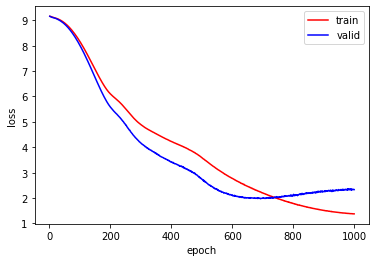

<Figure size 432x288 with 0 Axes>

In [39]:
x = np.arange(1, train_results.shape[0]+1)
plt.plot(x, train_results[:, 0], label='train', color='red')
plt.plot(x, valid_results[:, 0], label='valid', color='blue')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.savefig(opt.output_dir+'/loss.png')

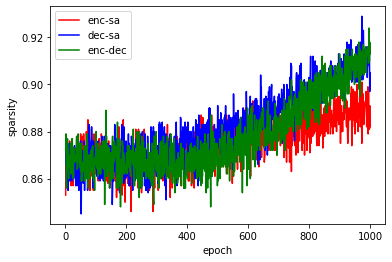

<Figure size 432x288 with 0 Axes>

In [40]:
plt.plot(x, sparsity_results[:, 0], label='enc-sa', color='red')
plt.plot(x, sparsity_results[:, 1], label='dec-sa', color='blue')
plt.plot(x, sparsity_results[:, 2], label='enc-dec', color='green')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('sparsity')
plt.show()
plt.savefig(opt.output_dir+'/sparsity.png')